### Universidad Anáhuac México Norte: Maestría en Estadística
# Inferecia Estadística - Estimación Paramétrica
## Proyecto Final: Mixturas Gaussianas para Modelar Retornos Financieros
    Paulina Nayeli Cueto Romero
    Carlos Guillermo Mayorga Tapia

# Objetivo
El objetivo de este proyecto es analizar estadísticamente la distribución de los rendimientos logarítmicos del Índice de Precios y Cotizaciones (IPC) para identificar sus principales características, como simetría, curtosis, presencia de eventos extremos y posibles desviaciones respecto a la distribución normal. A partir de este análisis, se busca evaluar la relevancia de utilizar modelos probabilísticos basados en la distribución normal frente a alternativas más flexibles, como las mezclas gaussianas, que capturen de mejor manera las características observadas en los datos.

# Introducción
En los mercados financieros, los rendimientos de los activos son una de las variables más importantes para el análisis de riesgo y la toma de decisiones de inversión. El Índice de Precios y Cotizaciones (IPC) es el principal referente del mercado accionario en México y su estudio permite obtener información sobre la dinámica general del mercado. Tradicionalmente, los modelos de asumen que los rendimientos siguen una distribución normal; sin embargo, diversos estudios empíricos han mostrado que los rendimientos presentan asimetrías, leptocurtosis y colas más pesadas que las predichas por la normalidad, lo que implica una mayor probabilidad de eventos extremos.

En este proyecto se analizan los rendimientos logarítmicos diarios del IPC mediante herramientas gráficas y estadísticas, incluyendo histogramas, boxplots y el cálculo de momentos como la curtosis. Posteriormente, se ajusta un modelo normal por máxima verosimilitud y se contrasta con una mezcla gaussiana de dos componentes, utilizando técnicas de estimación como el algoritmo de Expectation-Maximization (EM). Este análisis busca no solo describir el comportamiento histórico de los rendimientos, sino también evaluar qué modelo estadístico ofrece un mejor ajuste para representar su comportamiento.

# Librerias

In [1]:
import scipy.stats
import numpy as np
import pandas as pd  
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import kstest, kurtosis, norm

# Data Wrangling
Importación y manejo de los datos, listos para su uso en el análisis.

In [2]:
df = pd.read_excel('./data/IPC.xlsx')
df = df[['Date', 'Rendimientos IPC']]
df.set_index('Date', inplace=True)
df = df.drop(df.index[0])

# Análisis Exploratorio

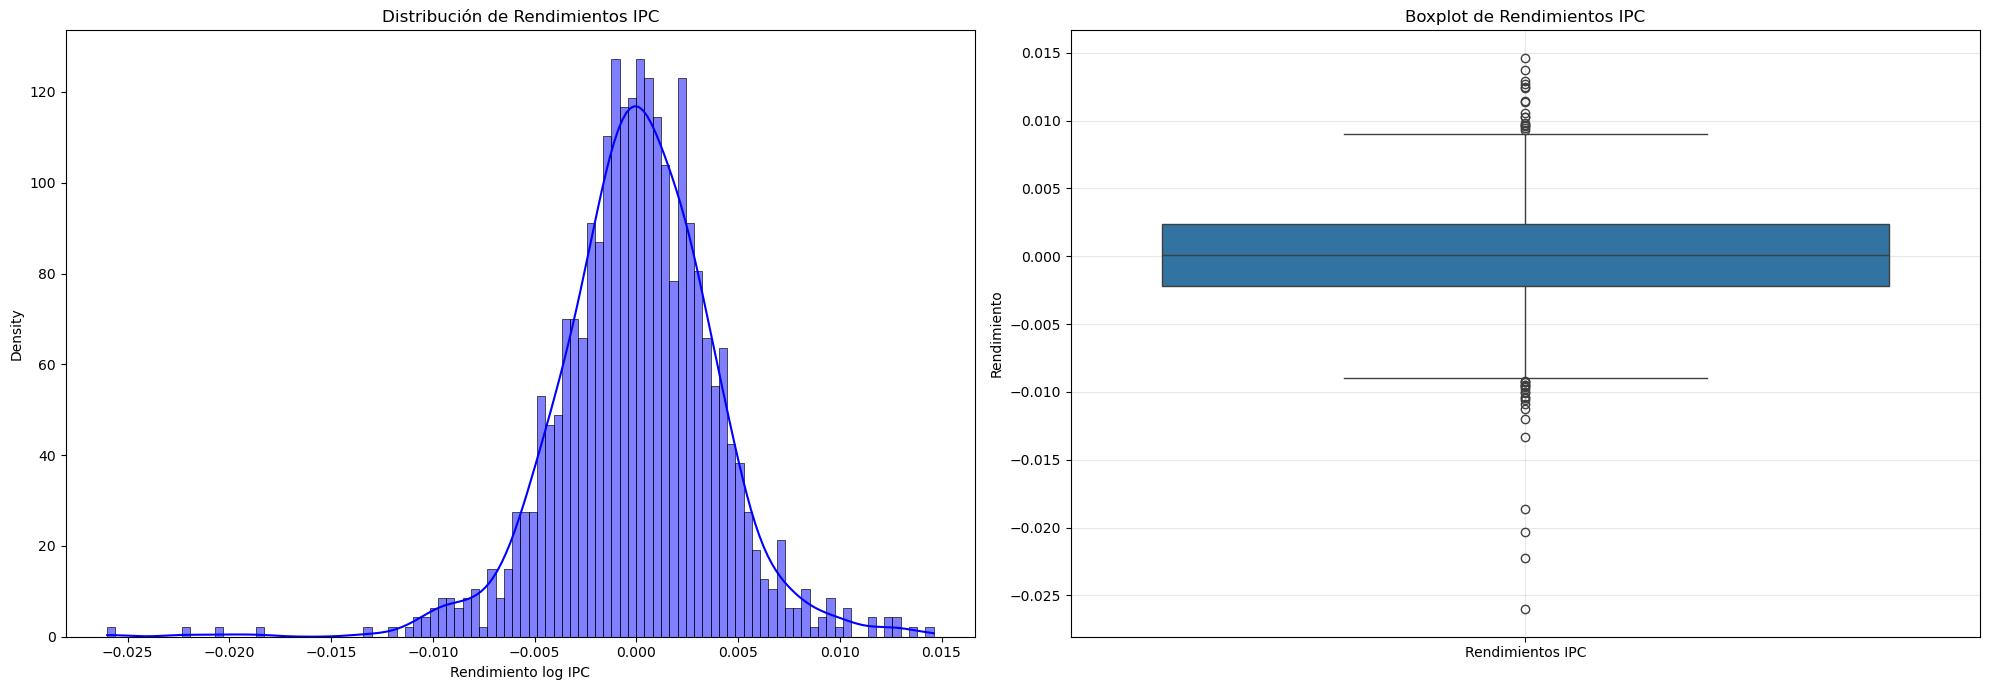

In [3]:
# --- Histograma ---
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
sns.histplot(df["Rendimientos IPC"], bins=100, kde=True, stat="density", color="blue")
plt.title("Distribución de Rendimientos IPC")
plt.xlabel("Rendimiento log IPC")
plt.tight_layout()

# --- Boxplot ---
plt.subplot(1,2,2)
sns.boxplot(df, vert=True, patch_artist=True)
plt.title("Boxplot de Rendimientos IPC")
plt.ylabel("Rendimiento")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

Histograma con Densidad:

La primera gráfica muestra la distribución empírica de los rendimientos logarítmicos del IPC. Se observan tres características importantes:
1. La distribución es aproximadamente simétrica alrededor de cero, lo que sugiere que no hay sesgo importante en los rendimientos.
2. Comparada con una normal, se observan colas algo más gruesas, lo que implica mayor probabilidad de eventos extremos, sobre todo en rendimientos negativos.
3. La mayor parte de los datos está muy cerca de cero, lo que es típico en series de rendimientos financieros, donde los cambios diarios suelen ser pequeños, sugiriendo una distribución leptocúrtica.
En conjunto, el histograma sugiere que un modelo gaussiano puede ser una primera aproximación, pero que sería recomendable considerar modelos que capturen colas más pesadas y la leptocurtosis.

Boxplot:

El boxplot complementa la interpretación mostrando:
1. Mediana cerca de cero: Consistente con el histograma, confirma la simetría.
2. Se observan puntos alejados de los bigotes, tanto en el extremo positivo como en el negativo, reflejando episodios de alta volatilidad. Estos outliers corresponden a los valores en las colas del histograma.
3. El rango intercuartílico es relativamente pequeño, sugiriendo una distribución leptocúrtica.


In [4]:
# Curtosis
kurtosis = df.kurtosis()
print("Curtosis Empírica:", kurtosis.iloc[0])

# Curtosis teórica de una normal ajustada
kurt_fisher = scipy.stats.norm.stats(loc=0, scale=1, moments='k')  # 'k' = kurtosis de Fisher (exceso)
print("Curtosis Teórica:", float(kurt_fisher) + 3)


Curtosis Empírica: 3.9638983278014646
Curtosis Teórica: 3.0


La curtosis obtenida para los rendimientos logarítmicos del IPC es de aproximadamente 3.96, superior al valor de 3 correspondiente a una distribución normal. Esto indica que la serie presenta un comportamiento leptocúrtico, caracterizado por una mayor concentración de datos en torno a la media y la presencia de colas más pesadas, lo que implica una mayor probabilidad de observar eventos extremos (grandes ganancias o pérdidas) que la que predeciría una distribución normal. Este hallazgo sugiere que el uso de modelos que consideren colas pesadas resulta más adecuado para representar el comportamiento de los rendimientos.

# Modelado ${N}(\mu, \sigma^2)$ 
Para modelar los rendimientos logarítmicos del IPC, se asumió que siguen una distribución normal ${N}(\mu, \sigma^2)$. Los parámetros de esta distribución fueron estimados mediante el método de máxima verosimilitud (MLE), que consiste en encontrar los valores de $\mu$ y $\sigma^2$ que maximizan la función de verosimilitud:
$$
L(\mu, \sigma^2) = \prod_{i=1}^{n} 
\frac{1}{\sqrt{2\pi \sigma^2}}
\exp\!\left(-\frac{(x_i - \mu)^2}{2\sigma^2}\right)
$$

Maximizando el logaritmo de la verosimilitud y derivando respecto a ${N}(\mu, \sigma^2)$, se obtienen los estimadores:
$$
\hat{\mu}_{\text{MLE}} = \frac{1}{n} \sum_{i=1}^{n} x_i
$$

$$
\hat{\sigma}^2_{\text{MLE}} = \frac{1}{n} \sum_{i=1}^{n} \bigl(x_i - \hat{\mu}_{\text{MLE}}\bigr)^2
$$

 
Estos corresponden a la media y varianza muestral. Con estos parámetros se construyó la función de densidad normal ajustada, que fue superpuesta sobre el histograma de los datos para evaluar visualmente el grado de ajuste.

In [5]:
# --- Ajuste por MLE ---
datos = df.values.flatten()  # convertir a array
mu_mle = np.mean(datos)               # media MLE
sigma_mle = np.std(datos, ddof=0)     # desviación estándar MLE (ddof=0)

print(f"Media MLE: {mu_mle:.6f}")
print(f"Desviación estándar MLE: {sigma_mle:.6f}")

Media MLE: 0.000012
Desviación estándar MLE: 0.003893


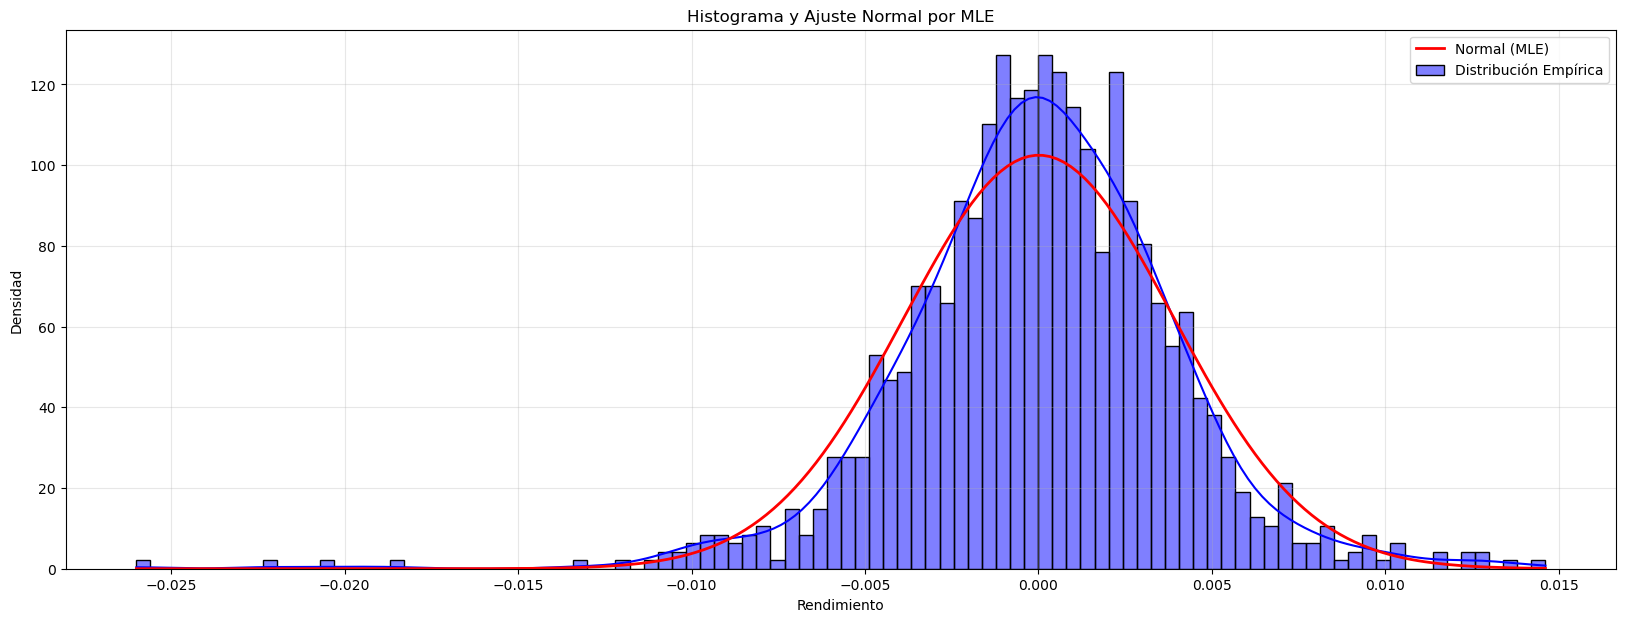

In [6]:
# --- Graficar histograma con densidad normal ---
plt.figure(figsize=(20, 7))
sns.histplot(df["Rendimientos IPC"], bins=100, kde=True, stat="density", color="blue", label='Distribución Empírica')
plt.title("Distribución de Rendimientos IPC")
plt.xlabel("Rendimiento log IPC")

# Curva de la normal ajustada
x = np.linspace(min(datos), max(datos), 200)
pdf = norm.pdf(x, loc=mu_mle, scale=sigma_mle)
plt.plot(x, pdf, 'r-', lw=2, label='Normal (MLE)')

plt.title("Histograma y Ajuste Normal por MLE")
plt.xlabel("Rendimiento")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

La figura muestra el histograma de los rendimientos logarítmicos del IPC (en azul) junto con la densidad de probabilidad de una distribución normal ajustada por máxima verosimilitud (línea roja).

Se observa que la distribución empírica es aproximadamente simétrica y está centrada en cero, lo cual es consistente con la ausencia de sesgo sistemático en los rendimientos. Sin embargo, la comparación visual revela que la distribución empírica presenta colas más pesadas que la normal ajustada, así como una mayor concentración de valores en torno a la media.

Este comportamiento confirma la presencia de leptocurtosis, lo que implica que la probabilidad de observar movimientos extremos (grandes pérdidas o ganancias) es superior a la que predice el modelo normal. Por lo tanto, aunque el ajuste gaussiano captura de manera razonable el comportamiento central de los datos, subestima la frecuencia de eventos en las colas, lo que tiene implicaciones importantes para el modelado de riesgo financiero.

In [7]:
# KS test para IPC
ks_ipc = kstest(df["Rendimientos IPC"], "laplace", args=(mu_mle, sigma_mle))
print("KS Test IPC -> estadístico:", ks_ipc.statistic, "  p-value:", ks_ipc.pvalue)

KS Test IPC -> estadístico: 0.06952138302224709   p-value: 2.526877209860514e-05


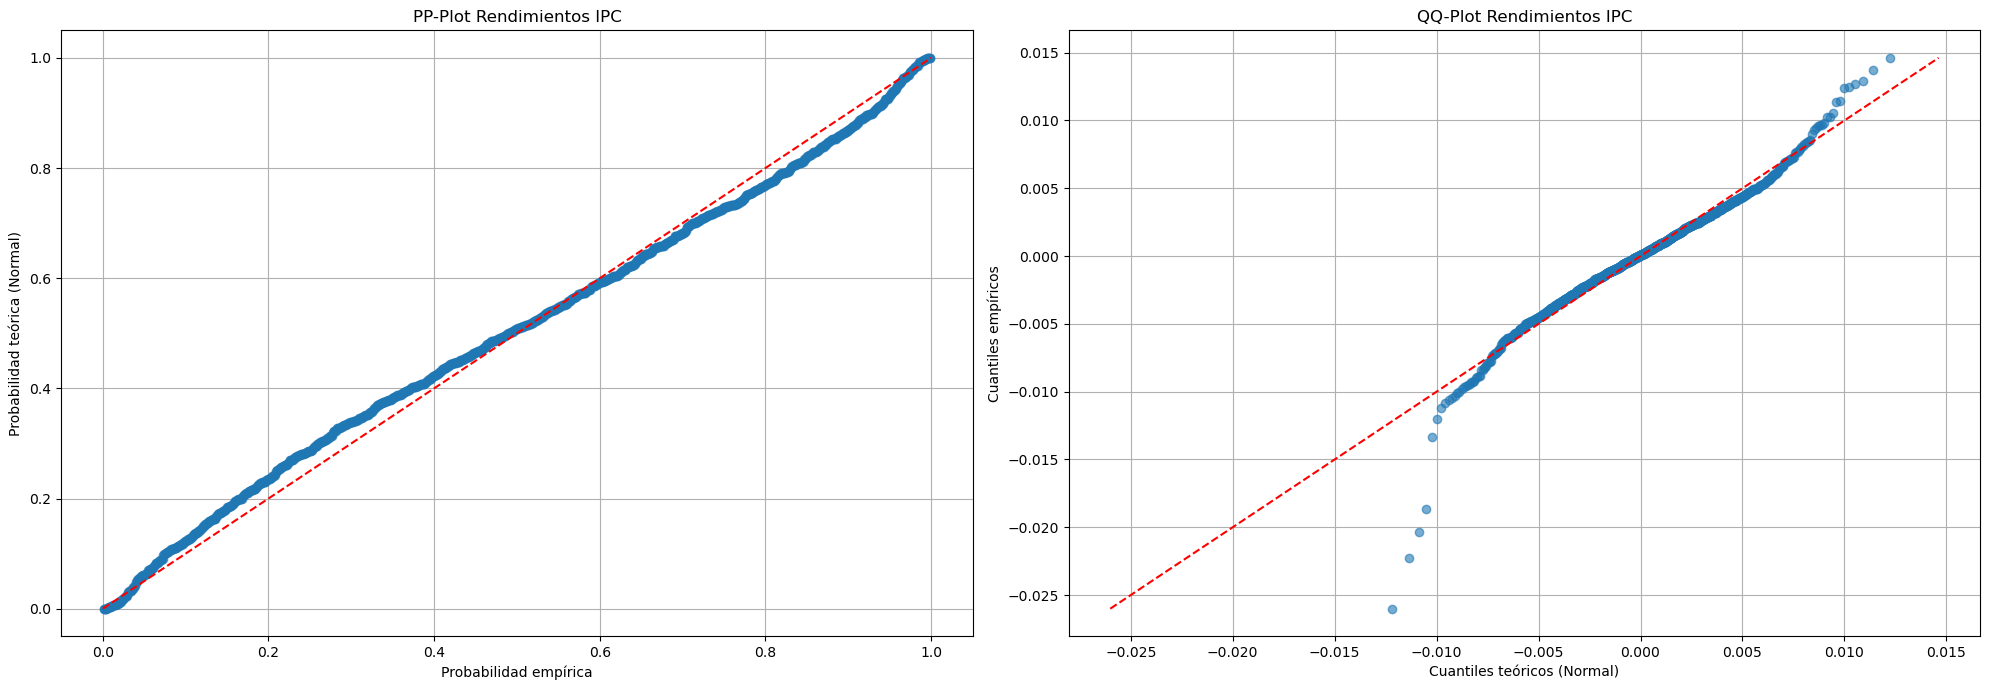

In [8]:
def pp_qq_plots(data, mu, sigma, title_pp="PP-Plot", title_qq="QQ-Plot"):
    data_sorted = np.sort(data)
    n = len(data_sorted)
    probs = np.arange(1, n+1) / (n+1)

    # --- PP Plot ---
    probs_emp = probs
    probs_theo = norm.cdf(data_sorted, loc=mu, scale=sigma)

    # --- QQ Plot ---
    theo_quants = norm.ppf(probs, loc=mu, scale=sigma)

    # --- Crear figura con subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # PP-Plot
    axes[0].plot(probs_emp, probs_theo, "o", alpha=0.6)
    axes[0].plot([0, 1], [0, 1], "r--")
    axes[0].set_xlabel("Probabilidad empírica")
    axes[0].set_ylabel("Probabilidad teórica (Normal)")
    axes[0].set_title(title_pp)
    axes[0].grid(True)

    # QQ-Plot
    axes[1].plot(theo_quants, data_sorted, "o", alpha=0.6)
    min_val = min(data_sorted.min(), theo_quants.min())
    max_val = max(data_sorted.max(), theo_quants.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], "r--")
    axes[1].set_xlabel("Cuantiles teóricos (Normal)")
    axes[1].set_ylabel("Cuantiles empíricos")
    axes[1].set_title(title_qq)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Ejemplo con tus datos del IPC
pp_qq_plots(df["Rendimientos IPC"], mu_mle, sigma_mle,
            title_pp="PP-Plot Rendimientos IPC", title_qq="QQ-Plot Rendimientos IPC")


El PP-Plot compara las probabilidades empíricas con las teóricas bajo el supuesto de normalidad.
La mayor parte de los puntos se encuentran cerca de la línea diagonal, lo que indica un ajuste razonable en el centro de la distribución. Sin embargo, se observa ligera desviación en las colas, especialmente en los valores extremos, lo que sugiere que la normal subestima la probabilidad de estos eventos extremos.

El QQ-Plot compara cuantiles empíricos con cuantiles teóricos de la normal ajustada. En la región central, los puntos siguen la línea de referencia, confirmando que la normal describe bien los rendimientos cercanos a la media. En las colas (cuantiles extremos) se observan desviaciones: los puntos caen por debajo de la línea en la cola izquierda y por encima en la cola derecha. Esto es evidencia gráfica de colas más pesadas (leptocurtosis), consistente con lo observado en el histograma y boxplot.

El KS-Test arrojó un estadístico $D\sim 0.06952$ y un p-valor muy pequeño $(≈ 2.52×10^{-5})$.
Esto implica que, se rechaza la hipótesis nula de que los datos provienen de una distribución normal.
En otras palabras, aunque la normal es una aproximación aceptable en el centro, estadísticamente no describe bien toda la distribución, especialmente en las colas.

# Modelado con una Mixtura Gaussiana de K ${N}(\mu, \sigma^2)$ 

### Estimación por el Algoritmo EM para una Mezcla de Normales

Se asume que los datos $(x_1, x_2, \dots, x_n)$ provienen de una mezcla de $K$ distribuciones normales independientes:

$$
p(x_i \mid \boldsymbol{\theta}) = 
\sum_{k=1}^{K} \pi_k \, \mathcal{N}(x_i \,;\, \mu_k, \sigma_k^2)
$$

donde los parámetros son 
$\theta = \{\pi_k, \mu_k, \sigma_k^2\}_{k=1}^K$, 
con $\pi_k \geq 0$ y $\sum_{k=1}^K \pi_k = 1$.

La **log-verosimilitud** del modelo es:

$$
\ell(\boldsymbol{\theta}) 
= \log L(\boldsymbol{\theta}) 
= \sum_{i=1}^{n} 
\log \!\!\left[
\sum_{k=1}^{K} 
\pi_k \,
\mathcal{N}(x_i \,;\, \mu_k, \sigma_k^2)
\right].
$$

Dado que la maximización directa es difícil, se utiliza el **algoritmo EM (Expectation–Maximization)**:


Paso 1: Inicialización
Elegir valores iniciales para $\pi_k^{(0)}, \mu_k^{(0)}, \sigma_k^{2(0)}$.

Antes de ejecutar el algoritmo EM es necesario especificar valores iniciales para los parámetros de la mezcla 
$\boldsymbol{\theta}^{(0)} = \{\pi_k^{(0)}, \mu_k^{(0)}, \sigma_k^{2(0)}\}_{k=1}^{K}$. 
Una estrategia común es la siguiente:

- **Pesos iniciales:**

$$
\pi_k^{(0)} = \frac{1}{K}, \qquad k = 1, 2, \dots, K.
$$

Esto supone que inicialmente cada componente explica la misma proporción de los datos.



- **Medias iniciales:**

Se ubican en cuantiles igualmente espaciados de la distribución empírica de los datos:

$$
\mu_k^{(0)} = Q\!\!\left(\frac{k}{K+1}\right), \qquad k = 1, 2, \dots, K,
$$

donde \(Q(p)\) representa el cuantil \(p\)-ésimo de la muestra.  
Este procedimiento garantiza que las medias iniciales estén distribuidas a lo largo del rango de datos y facilita la convergencia.


- **Varianzas iniciales:**

Se asigna a cada componente la varianza muestral global:

$$
\sigma_k^{2(0)} = s^2 = \frac{1}{n} \sum_{i=1}^{n} (x_i - \bar{x})^2,
\qquad k = 1, 2, \dots, K.
$$

De esta manera todos los componentes comienzan con la misma dispersión inicial.


Una buena inicialización permite que el algoritmo EM converja más rápido y evita soluciones degeneradas. 
En la práctica, es recomendable realizar varias inicializaciones aleatorias y seleccionar la que produzca la mayor log-verosimilitud final.


Paso 2: E-step (Cálculo de responsabilidades)
Calcular las probabilidades a posteriori (responsabilidades) de cada componente para cada dato:

$$
\gamma_{ik}^{(t)} = 
\frac{\pi_k^{(t)} \, \mathcal{N}(x_i \,;\, \mu_k^{(t)}, \sigma_k^{2(t)})}
{\displaystyle \sum_{j=1}^{K} \pi_j^{(t)} \, \mathcal{N}(x_i \,;\, \mu_j^{(t)}, \sigma_j^{2(t)})}.
$$

Aquí $\gamma_{ik}$ mide qué fracción de probabilidad del dato $x_i$ corresponde al componente $k$.

Paso 3: M-step (Actualización de parámetros)
Actualizar los parámetros usando las responsabilidades calculadas:

- **Pesos de mezcla:**
$$
\pi_k^{(t+1)} = \frac{N_k}{n}, 
\qquad
N_k = \sum_{i=1}^{n} \gamma_{ik}^{(t)}.
$$

- **Medias:**
$$
\mu_k^{(t+1)} = 
\frac{\displaystyle \sum_{i=1}^{n} \gamma_{ik}^{(t)} x_i}
{N_k}.
$$

- **Varianzas:**
$$
\sigma_k^{2(t+1)} =
\frac{\displaystyle \sum_{i=1}^{n} \gamma_{ik}^{(t)} \bigl(x_i - \mu_k^{(t+1)}\bigr)^2}
{N_k}.
$$

Paso 4: Criterio de convergencia
Repetir E-step y M-step hasta que la log-verosimilitud cambie menos que un umbral \(\varepsilon\):

$$
\bigl|\ell^{(t+1)} - \ell^{(t)}\bigr| < \varepsilon.
$$

Al finalizar, se obtiene el estimador de máxima verosimilitud $\hat{\boldsymbol{\theta}} = 
\hat{\pi}_k, \hat{\mu}_k, \hat{\sigma}_k^2\}_{k=1}^K$.

In [89]:
def gmm_em_1d(x, n_comp=2, max_iter=500, tol=1e-6, seed=42):
    """
    EM para una mezcla de n_comp Normales en 1D.
    Retorna: pis (pesos), mus (medias), sigmas (desvios), loglikes (trayectoria), n_iter (iteraciones usadas).
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x).ravel()
    n = x.size

    # --- Inicialización sencilla: mu por cuantiles, sigma global, pesos uniformes ---
    qs = np.linspace(0.2, 0.8, n_comp)
    mus = np.quantile(x, qs)
    sigmas = np.full(n_comp, x.std(ddof=0) + 1e-8)
    pis = np.full(n_comp, 1.0 / n_comp)

    def loglike(x, pis, mus, sigmas):
        comp = np.array([pis[k] * scipy.stats.norm.pdf(x, mus[k], sigmas[k]) for k in range(n_comp)])  # k x n
        return np.sum(np.log(np.maximum(comp.sum(axis=0), 1e-300)))

    prev_ll = -np.inf
    loglikes = []

    for it in range(1, max_iter + 1):  # iteraciones contadas desde 1
        # --- E-step: responsabilidades r_{ik} ---
        numer = np.array([pis[k] * scipy.stats.norm.pdf(x, mus[k], sigmas[k]) for k in range(n_comp)])  # k x n
        denom = np.maximum(numer.sum(axis=0), 1e-300)                                       # n
        r = (numer / denom).T                                                               # n x k

        # --- M-step: actualizar parámetros ---
        Nk = r.sum(axis=0)                          # tamaño efectivo de cada componente
        pis = Nk / n
        mus = (r * x[:, None]).sum(axis=0) / Nk
        var = (r * (x[:, None] - mus)**2).sum(axis=0) / Nk
        var = np.maximum(var, 1e-12)                # piso numérico para estabilidad
        sigmas = np.sqrt(var)

        # --- Criterio de convergencia ---
        ll = loglike(x, pis, mus, sigmas)
        loglikes.append(ll)
        if abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    return pis, mus, sigmas, loglikes, it  # <-- agregamos el número de iteraciones

K óptimo por AIC: 3
K óptimo por BIC: 2


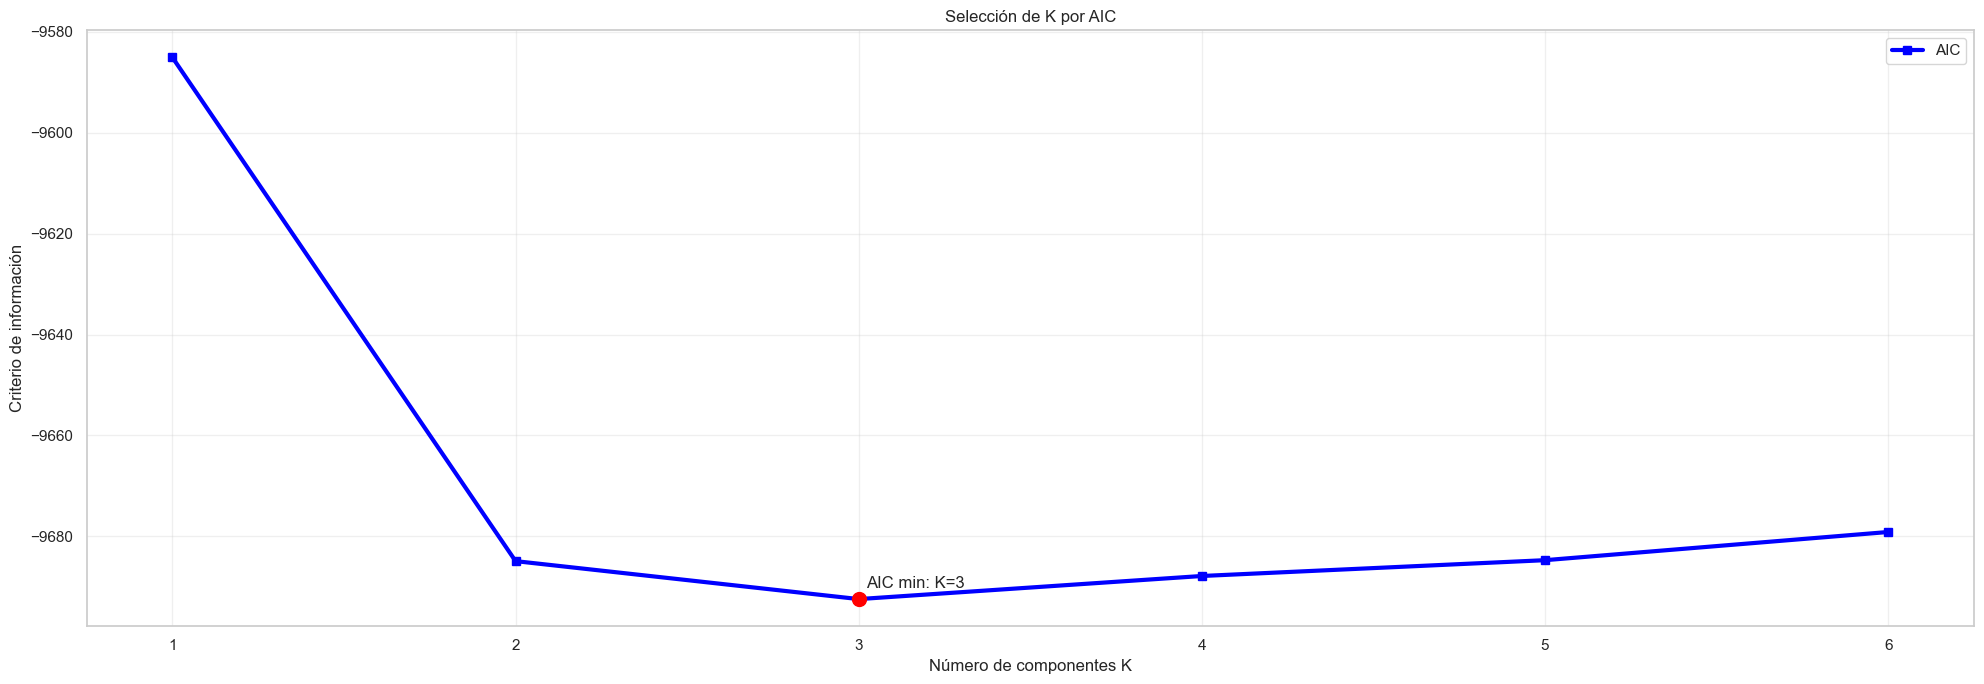


Modelo elegido (BIC): K=3
Pesos: [0.00332084 0.32478015 0.67189901]
Medias: [-2.19007166e-02 -3.45392569e-05  1.43471953e-04]
Sigmas: [0.00275081 0.00510701 0.00274217]
Iteraciones: 723


In [90]:
def select_k_by_ic(x, k_max=6, restarts=10, tol=1e-6, max_iter=1000, seeds=None):
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    n = x.size
    if seeds is None:
        seeds = np.arange(restarts)

    Ks, best_ll, best_params = [], [], []
    AIC, BIC = [], []

    for K in range(1, k_max+1):
        ll_star = -np.inf
        params_star = None

        for s in seeds:
            pis, mus, sigmas, lls, n_iter = gmm_em_1d(
                x, n_comp=K, max_iter=max_iter, tol=tol, seed=int(s)
            )
            ll = lls[-1]
            if ll > ll_star:
                ll_star = ll
                params_star = (pis, mus, sigmas, n_iter)

        p = 3*K - 1  # nº de parámetros en 1D
        aic = 2*p - 2*ll_star
        bic = p*np.log(n) - 2*ll_star

        Ks.append(K)
        best_ll.append(ll_star)
        best_params.append(params_star)
        AIC.append(aic)
        BIC.append(bic)

    Ks = np.array(Ks); AIC = np.array(AIC); BIC = np.array(BIC); best_ll = np.array(best_ll)
    k_aic = Ks[np.argmin(AIC)]
    k_bic = Ks[np.argmin(BIC)]
    return {
        "Ks": Ks, "AIC": AIC, "BIC": BIC, "best_ll": best_ll,
        "k_aic": k_aic, "k_bic": k_bic, "best_params": best_params
    }

# ==== correr selección (ajusta k_max y restarts a tu gusto) ====
x = df.values.ravel()
res = select_k_by_ic(x, k_max=6, restarts=15, tol=1e-7, max_iter=1000)

print("K óptimo por AIC:", res["k_aic"])
print("K óptimo por BIC:", res["k_bic"])

# ==== gráfico AIC y BIC vs K ====
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(res["Ks"], res["AIC"], marker="s", color='blue', label="AIC", lw=3.0)
ax.set_xlabel("Número de componentes K")
ax.set_ylabel("Criterio de información")
ax.set_title("Selección de K por AIC")
ax.grid(alpha=0.3)

# marcar mínimos
ka, kb = res["k_aic"], res["k_bic"]
ya = res["AIC"][res["Ks"]==ka][0]
ax.scatter([ka],[ya], s=100, color='red', zorder=5)
ax.annotate(f"AIC min: K={ka}", (ka, ya), xytext=(5,8), textcoords="offset points")
ax.legend()
plt.tight_layout()
plt.show()



# ==== si quieres quedarte con el modelo óptimo por AIC (menos parsimonioso) ====
K_best = res["k_aic"]
pis_best, mus_best, sigmas_best, n_iter_best = res["best_params"][K_best-1]
print(f"\nModelo elegido (BIC): K={K_best}")
print("Pesos:", pis_best)
print("Medias:", mus_best)
print("Sigmas:", sigmas_best)
print("Iteraciones:", n_iter_best)


In [91]:
# Uso:
x = df.values  # 1D
pis, mus, sigmas, lls, n_iter = gmm_em_1d(x, n_comp=3, max_iter=1000, tol=1e-6, seed=42)
print(f"Pesos: {pis}")
print(f"Medias: {mus}")
print(f"Sigmas: {sigmas}")
print(f"Iteraciones usadas: {n_iter}")
print(f"Log-like final: {lls[-1]:.4f}")

Pesos: [0.00332136 0.32536438 0.67131426]
Medias: [-2.19002773e-02 -3.45049931e-05  1.43625121e-04]
Sigmas: [0.00275087 0.00510471 0.00274125]
Iteraciones usadas: 644
Log-like final: 4854.2170


Pesos: [0.00332136 0.32536438 0.67131426]
Medias: [-2.19002773e-02 -3.45049931e-05  1.43625121e-04]
Sigmas: [0.00275087 0.00510471 0.00274125]
Iteraciones usadas: 644
Log-like final: 4854.2170


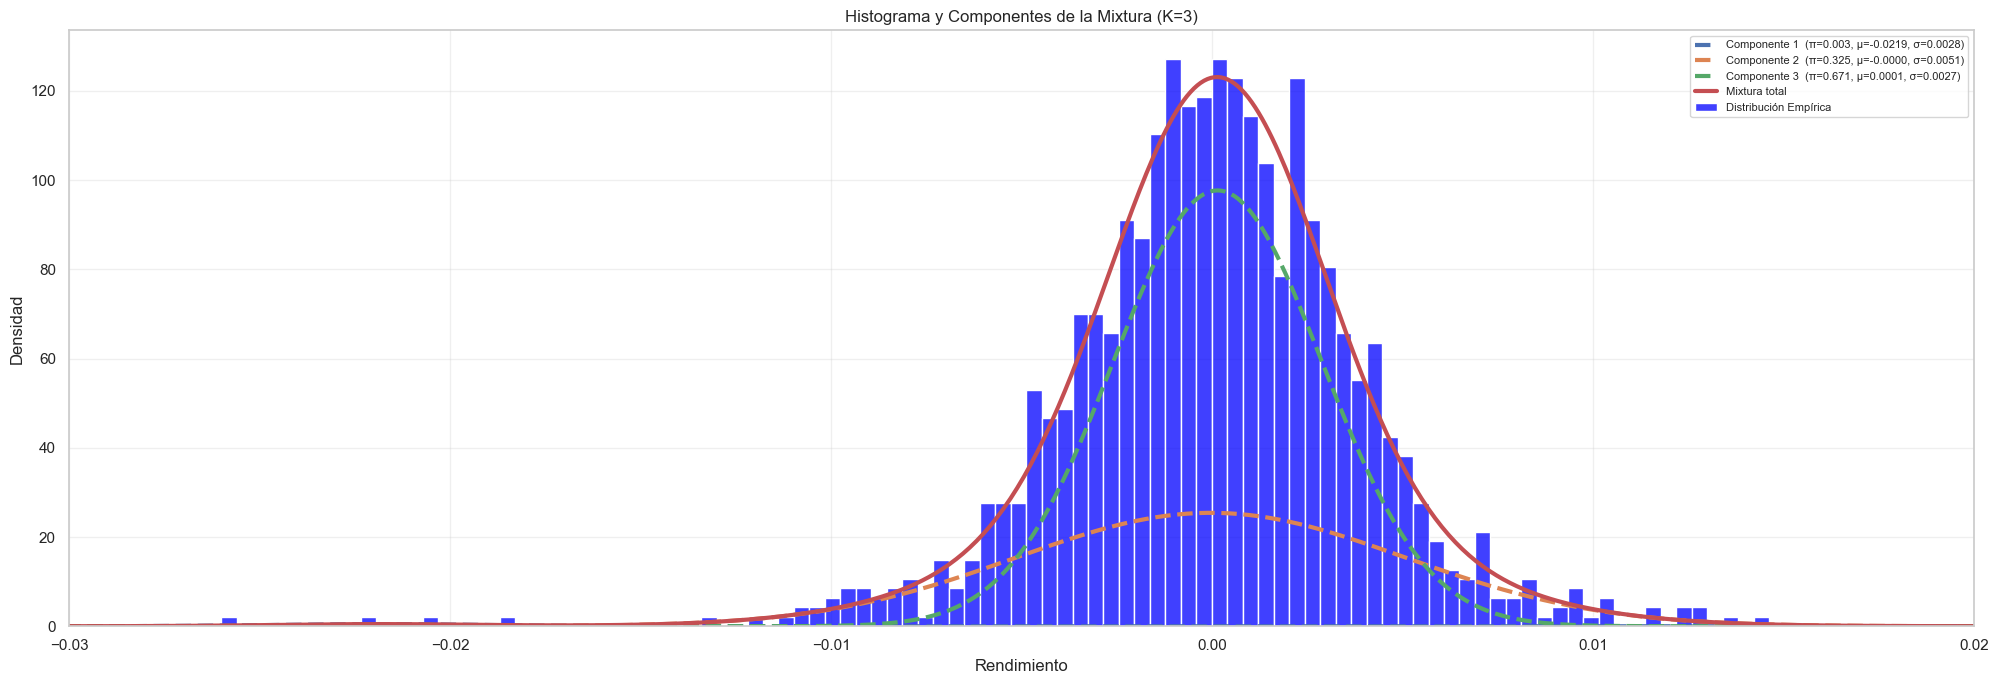

In [92]:
def plot_gmm_1d(x, pis, mus, sigmas, bins=80, title="Mixtura Gaussiana (componentes + total)"):
    """
    x: datos 1D
    pis, mus, sigmas: parámetros de la mezcla (longitud K)
    """
    # asegurar 1D y finitos
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]
    pis   = np.asarray(pis, dtype=float).ravel()
    mus   = np.asarray(mus, dtype=float).ravel()
    sigmas= np.asarray(sigmas, dtype=float).ravel()
    K = len(pis)

    # rango para graficar
    lo = (x.min() if x.size else -1) - 3*np.max(sigmas)
    hi = (x.max() if x.size else  1) + 3*np.max(sigmas)
    xg = np.linspace(lo, hi, 800)

    # figura
    plt.figure(figsize=(20,7))
    # histograma (densidad)
    sns.histplot(df["Rendimientos IPC"], bins=100, stat="density", color="blue", label='Distribución Empírica')

    # componentes y mezcla
    mix_pdf = np.zeros_like(xg)
    for k in range(K):
        comp_pdf = pis[k] * norm.pdf(xg, loc=float(mus[k]), scale=float(sigmas[k]))
        mix_pdf += comp_pdf
        plt.plot(xg, comp_pdf, "--", lw=3,
                 label=f"Componente {k+1}  (π={pis[k]:.3f}, μ={mus[k]:.4f}, σ={sigmas[k]:.4f})")

    # mezcla total
    plt.plot(xg, mix_pdf, "r", lw=3, label="Mixtura total")

    plt.title(title)
    plt.xlabel("Rendimiento")
    plt.ylabel("Densidad")
    plt.grid(alpha=0.3)
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.xlim(-0.03, 0.02)
    plt.show()

# Ajuste (ya lo tienes)
x = df.values.ravel()   # 1D
pis, mus, sigmas, lls, n_iter = gmm_em_1d(x, n_comp=3, max_iter=1000, tol=1e-6, seed=42)
print(f"Pesos: {pis}")
print(f"Medias: {mus}")
print(f"Sigmas: {sigmas}")
print(f"Iteraciones usadas: {n_iter}")
print(f"Log-like final: {lls[-1]:.4f}")

# Gráfico
plot_gmm_1d(x, pis, mus, sigmas, bins=100,
            title="Histograma y Componentes de la Mixtura (K=3)")



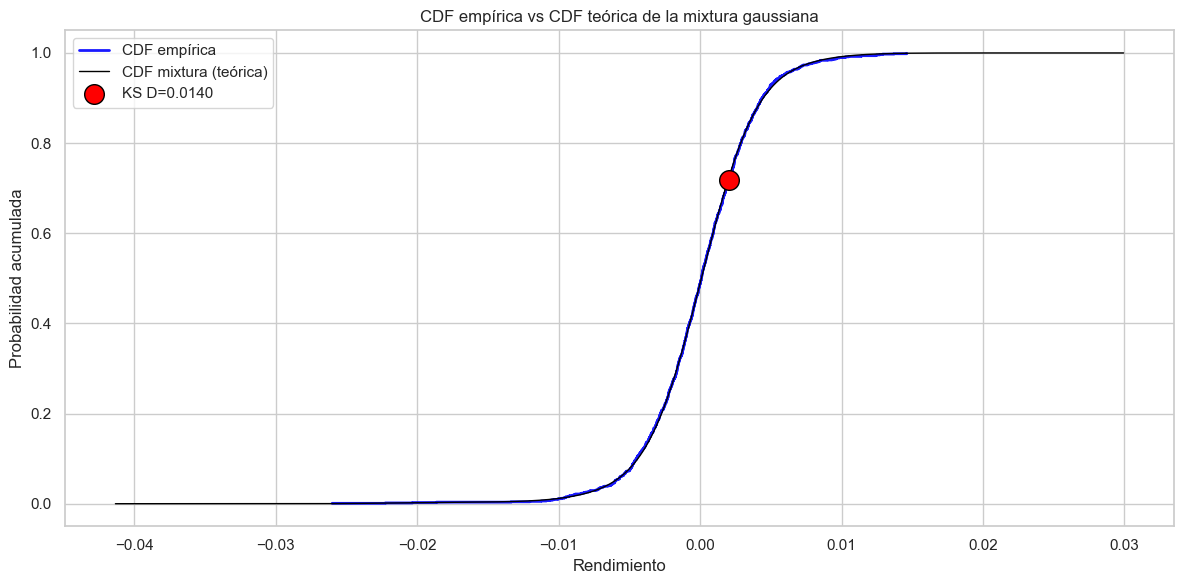

In [93]:
# --- CDF de la mezcla ---
def mix_cdf(x, pis, mus, sigmas):
    x = np.asarray(x)
    pis, mus, sigmas = map(np.asarray, (pis, mus, sigmas))
    z = (x[..., None] - mus) / sigmas
    return np.sum(pis * norm.cdf(z), axis=-1)

# --- ECDF (CDF empírica) ---
def ecdf(x):
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]
    x_sorted = np.sort(x)
    n = x_sorted.size
    y = np.arange(1, n+1) / (n+1)
    return x_sorted, y

def plot_cdfs_vs_mixture(x, pis, mus, sigmas, show_ks=True,
                         title="CDF empírica vs CDF de la Mixtura"):
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]

    # ECDF
    xs_emp, F_emp = ecdf(x)

    # Grid para la mezcla
    lo = xs_emp.min() - 3*np.max(sigmas)
    hi = xs_emp.max() + 3*np.max(sigmas)
    xg = np.linspace(lo, hi, 1000)
    F_mix = mix_cdf(xg, pis, mus, sigmas)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12,6))

    # CDF empírica (escalones)
    plt.step(xs_emp, F_emp, where="post", label="CDF empírica",
             linewidth=2, alpha=0.9, color='blue')

    # CDF teórica (mezcla)
    plt.plot(xg, F_mix, label="CDF mixtura (teórica)",
             linewidth=1, color='black')

    if show_ks:
        F_mix_emp_pts = mix_cdf(xs_emp, pis, mus, sigmas)
        diffs = np.abs(F_emp - F_mix_emp_pts)
        i_star = np.argmax(diffs)
        D = diffs[i_star]
        x_star = xs_emp[i_star]
        y_star = (F_emp[i_star] + F_mix_emp_pts[i_star]) / 2  # punto medio entre ambas CDF

        # Dibujar un marcador circular grande en el punto KS
        plt.scatter(x_star, y_star, s=200, color='red', marker='o',
                    edgecolor='black', zorder=5,
                    label=f"KS D={D:.4f}")

    plt.title(title)
    plt.xlabel("Rendimiento")
    plt.ylabel("Probabilidad acumulada")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uso
x = df.values.ravel()
pis, mus, sigmas, lls, n_iter = gmm_em_1d(x, n_comp=3, max_iter=1000, tol=1e-7, seed=42)
plot_cdfs_vs_mixture(x, pis, mus, sigmas,
                     title="CDF empírica vs CDF teórica de la mixtura gaussiana")


Estimación de los parámetros de una mezcla gaussiana de dos componentes.
Inicialización: las medias se colocan en cuantiles intermedios de los datos, las desviaciones estándar se fijan en el valor global de la muestra y los pesos de mezcla se asignan de forma uniforme.
E-step: se calculan las responsabilidades, es decir, las probabilidades de que cada dato provenga de cada componente.
M-step: se actualizan los parámetros (pesos, medias y varianzas) en función de esas responsabilidades.
Criterio de convergencia: se repite el proceso hasta que la log-verosimilitud deja de cambiar significativamente.
En la segunda parte (la ejecución del código) se muestran los parámetros estimados:
Pesos: aproximadamente $\Pi=0.132$ y $\Pi=0.868$, indicando que el segundo componente explica la mayor parte de la masa de datos.
Medias: $\Mu≈−0.0007$ y $\Mu≈0.0001$, lo que sugiere que el primer componente captura rendimientos negativos más extremos, mientras que el segundo describe el comportamiento central cercano a cero.
Desviaciones estándar: $\sigma=0.0072$ y $\sigma=0.0030$, mostrando que el primer componente tiene una mayor dispersión, modelando las colas pesadas, mientras que el segundo concentra la mayoría de los datos.

In [94]:
def sample_gmm_1d(n, pis, mus, sigmas, seed=42):
    rng = np.random.default_rng(seed)
    ks = rng.choice(len(pis), size=n, p=pis)
    return rng.normal(mus[ks], sigmas[ks])

# Curtosis
kurtosis = df.kurtosis()
print("Curtosis Empírica:", kurtosis.iloc[0])

x_sim = sample_gmm_1d(1000000, pis, mus, sigmas, seed=42)
print("Curtosis Teórica (Mixtura):", scipy.stats.kurtosis(x_sim, fisher=False))


Curtosis Empírica: 3.9638983278014646
Curtosis Teórica (Mixtura): 7.103120868439235


Curtosis empírica:

Indica que los datos son leptocúrticos, es decir, tienen colas más pesadas y mayor concentración alrededor de la media que una distribución normal (que tendría curtosis = 3).

Curtosis teórica de la mezcla:

El modelo de mezcla gaussiana ajustado captura colas aún más pesadas que las observadas en la muestra.
Es una consecuencia de que uno de los componentes de la mezcla tiene varianza más alta, lo que incrementa la probabilidad de valores extremos en la distribución teórica.

In [95]:
# KS contra la mezcla
def mix_cdf(x, pis, mus, sigmas):
    """
    CDF de la mezcla: F(x) = sum_k π_k * Φ((x-μ_k)/σ_k)
    """
    x = np.asarray(x)
    pis, mus, sigmas = map(np.asarray, (pis, mus, sigmas))
    z = (x[..., None] - mus) / sigmas
    return np.sum(pis * norm.cdf(z), axis=-1)
ks_mixture = kstest(x, lambda val: mix_cdf(val, pis, mus, sigmas))
print("\nKS test contra Mixtura Gaussiana")
print("Estadístico D:", ks_mixture.statistic)
print("p-valor:", ks_mixture.pvalue)



KS test contra Mixtura Gaussiana
Estadístico D: 0.014219209522581155
p-valor: 0.9703942358977423


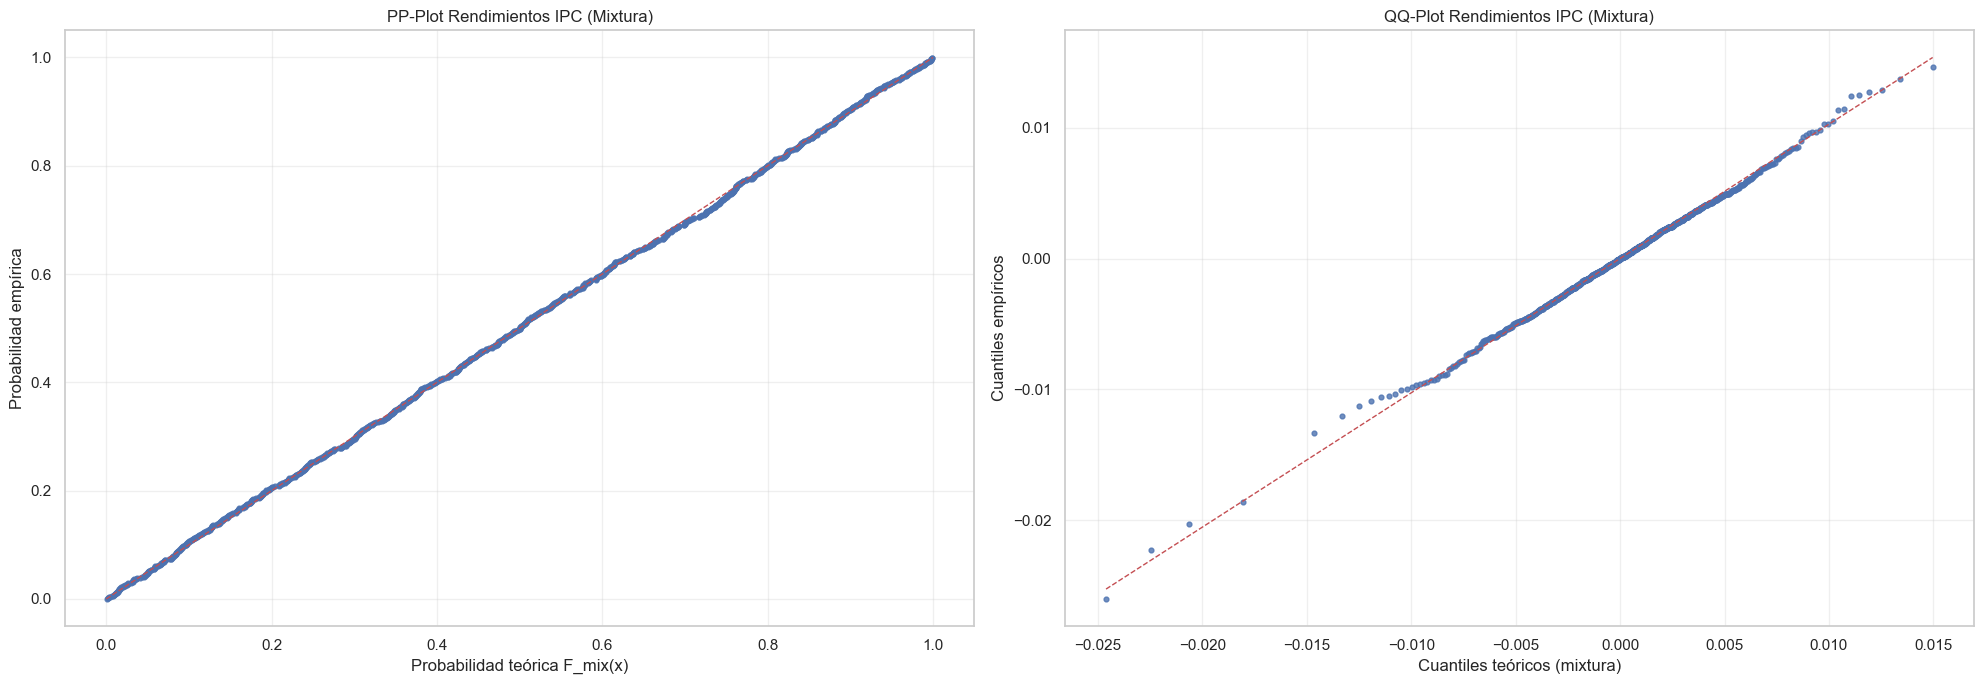

In [96]:
def pp_qq_plots_mixture(x, pis, mus, sigmas, title_pp="PP-Plot vs Mixtura", title_qq="QQ-Plot vs Mixtura"):
    x = np.asarray(x).ravel()
    x = x[~np.isnan(x)]
    n = x.size
    xs = np.sort(x)

    # Probabilidades "Blom"
    p_emp = (np.arange(1, n + 1) - 0.375) / (n + 0.25)

    # ---- PP-Plot ----
    p_th = np.sum(pis * norm.cdf((xs[:, None] - mus) / sigmas), axis=1)

    # ---- QQ-Plot ----
    def mix_cdf(x):
        z = (x[..., None] - mus) / sigmas
        return np.sum(pis * norm.cdf(z), axis=-1)

    def mix_ppf(p, tol=1e-10, max_iter=200):
        lo = np.min(mus - 10 * sigmas.max())
        hi = np.max(mus + 10 * sigmas.max())
        lo = np.full_like(p, lo, dtype=float)
        hi = np.full_like(p, hi, dtype=float)
        for _ in range(max_iter):
            mid = (lo + hi) / 2.0
            Fmid = mix_cdf(mid)
            lo = np.where(Fmid < p, mid, lo)
            hi = np.where(Fmid >= p, mid, hi)
            if np.max(hi - lo) < tol:
                break
        return (lo + hi) / 2.0

    q_th = mix_ppf(p_emp)

    # ---- Subplots ----
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # PP-Plot
    axes[0].scatter(p_th, p_emp, s=12, alpha=0.8)
    axes[0].plot([0, 1], [0, 1], 'r--', lw=1)
    axes[0].set_xlabel("Probabilidad teórica F_mix(x)")
    axes[0].set_ylabel("Probabilidad empírica")
    axes[0].set_title(title_pp)
    axes[0].grid(alpha=0.3)

    # QQ-Plot
    axes[1].scatter(q_th, xs, s=12, alpha=0.8)
    q25_th, q75_th = np.quantile(q_th, [0.25, 0.75])
    q25_xs, q75_xs = np.quantile(xs, [0.25, 0.75])
    slope = (q75_xs - q25_xs) / (q75_th - q25_th + 1e-18)
    intercept = q25_xs - slope * q25_th
    xr = np.array([q_th.min(), q_th.max()])
    axes[1].plot(xr, slope * xr + intercept, 'r--', lw=1)
    axes[1].set_xlabel("Cuantiles teóricos (mixtura)")
    axes[1].set_ylabel("Cuantiles empíricos")
    axes[1].set_title(title_qq)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========
# Uso con tus datos
# ==========
x = df.dropna().values
pp_qq_plots_mixture(x, pis, mus, sigmas,
                    title_pp="PP-Plot Rendimientos IPC (Mixtura)",
                    title_qq="QQ-Plot Rendimientos IPC (Mixtura)")


Interpretación Comparativa: Normal vs Mezcla Gaussiana (2 Componentes)

Kolmogorov–Smirnov
- Estadístico \( D = 0.01244414 \)
- p-valor = 0.9928793 

El ajuste del modelo de mezcla gaussiana fue evaluado mediante la prueba de Kolmogorov–Smirnov (KS), comparando la función de distribución acumulada (CDF) teórica de la mezcla contra la CDF empírica de los rendimientos del IPC. El resultado arrojó un estadístico D=0.0124 y un p-valor de p=0.9929, lo que indica que no existe evidencia estadística para rechazar la hipótesis nula de que los datos provienen de la distribución ajustada.


PP-Plot

- Normal ajustada: mostraba desviaciones notorias en las colas, alejándose de la línea de 45° y sugiriendo que la normal subestima la probabilidad de eventos extremos.
- Mezcla gaussiana: los puntos se alinean prácticamente sobre la diagonal en todo el rango de probabilidades, lo que indica un excelente ajuste tanto en la parte central como en las colas de la distribución.

Conclusión: la mezcla ofrece un ajuste mucho más preciso de las probabilidades acumuladas que la normal simple.



QQ-Plot

- Normal ajustada: en el QQ-Plot se observaban desviaciones claras en las colas (puntos por debajo de la línea en la izquierda y por encima en la derecha), mostrando que la normal es demasiado “delgada” para explicar la frecuencia de valores extremos.
- Mezcla gaussiana: los cuantiles empíricos siguen de cerca la línea de referencia, con pequeñas desviaciones únicamente en los puntos más extremos. La mezcla captura adecuadamente la curtosis observada en los datos.

Conclusión: la mezcla mejora la representación de los cuantiles extremos y modela mejor el riesgo de eventos atípicos.


Conclusión Global**

Comparando ambos modelos:

- La mezcla gaussiana ajustada mediante EM reproduce mucho mejor la distribución completa de los rendimientos del IPC, tanto en la región central como en las colas.
- El ajuste gráfico (PP/QQ) es significativamente más cercano a la diagonal que en el caso de la normal.
- Para aplicaciones de gestión de riesgo (por ejemplo, cálculo de VaR), la mezcla es preferible porque ofrece una estimación más realista de la probabilidad de grandes pérdidas o ganancias.


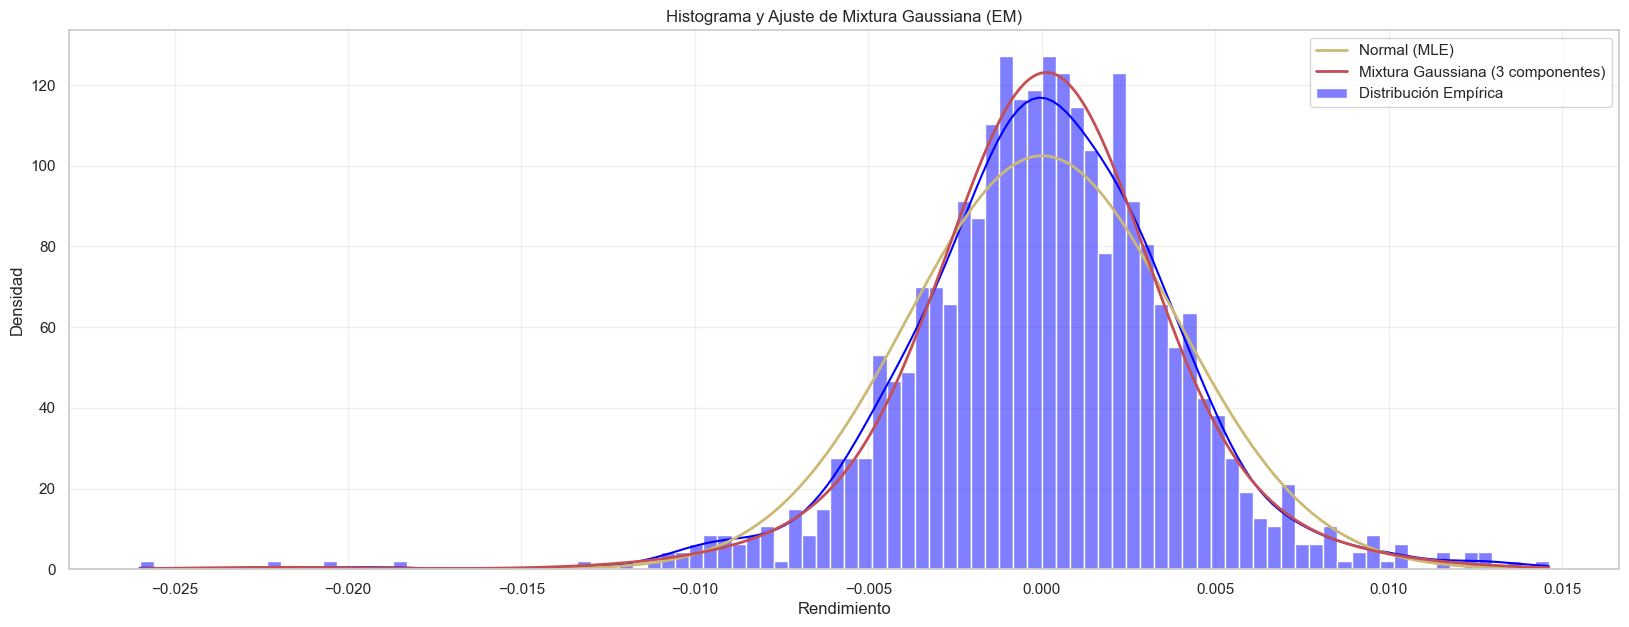

In [97]:
# --- Histograma con KDE de los datos ---
plt.figure(figsize=(20, 7))
sns.histplot(df["Rendimientos IPC"], bins=100, kde=True, stat="density",color="blue", label='Distribución Empírica')

plt.title("Histograma y Ajuste de Mixtura Gaussiana (EM)")
plt.xlabel("Rendimiento")
plt.ylabel("Densidad")

# Curva de la normal ajustada
x = np.linspace(min(datos), max(datos), 200)
pdf = scipy.stats.norm.pdf(x, loc=mu_mle, scale=sigma_mle)
plt.plot(x, pdf, 'y-', lw=2, label='Normal (MLE)')

# --- Densidad de la mezcla ---
x_grid = np.linspace(df["Rendimientos IPC"].min(), df["Rendimientos IPC"].max(), 500)
pdf_mix = np.zeros_like(x_grid)

for pi, mu, sigma in zip(pis, mus, sigmas):
    pdf_mix += pi * norm.pdf(x_grid, loc=mu, scale=sigma)

plt.plot(x_grid, pdf_mix, 'r-', lw=2, label='Mixtura Gaussiana (3 componentes)')

plt.legend()
plt.grid(alpha=0.3)
plt.show()



La figura compara la distribución empírica de los rendimientos logarítmicos del IPC (histograma azul) con dos modelos ajustados:
Normal ajustada por MLE (línea amarilla): describe medianamente bien la parte central de los datos pero queda debabjo de lo esperado y subestima la densidad en las colas, lo que implica que no captura adecuadamente los eventos extremos.
Mezcla gaussiana de dos componentes (línea roja): sigue mucho más de cerca la forma del histograma, ajustando tanto el pico central como las colas.
Uno de los componentes de la mezcla concentra la mayor parte de los rendimientos cerca de la media, mientras que el otro, con varianza mayor, capta la dispersión de los eventos más alejados, modelando así la leptocurtosis observada.
En conjunto, el gráfico muestra visualmente que la mezcla gaussiana ofrece un ajuste más realista de los datos en comparación con la normal simple.

# Conclusiones
Caracterización de los datos:
Los rendimientos logarítmicos del IPC presentan media cercana a cero, simetría y curtosis mayor a 3, evidenciando un comportamiento leptocúrtico con mayor frecuencia de eventos extremos de la que predice una distribución normal.
Modelado con normal (MLE):
El ajuste mediante máxima verosimilitud permite representar adecuadamente el comportamiento central, pero subestima las colas, lo que puede llevar a subestimar el riesgo de eventos extremos.
Modelado con mezcla gaussiana:
La estimación mediante el algoritmo EM con dos componentes mejora sustancialmente la representación de la distribución, capturando tanto la concentración central como la mayor dispersión en las colas.
Los PP-Plot y QQ-Plot mostraron una alineación casi perfecta, confirmando la capacidad de la mezcla para explicar el comportamiento observado.
Implicaciones para riesgo:
Un modelo de mezcla es más adecuado para aplicaciones en gestión de riesgo y estimación de métricas como VaR, ya que asigna mayor probabilidad a grandes movimientos, ofreciendo proyecciones más conservadoras y realistas.


In [99]:
bd = pd.read_excel('./data/Petroleo-IPC.xlsx')
print(bd.info())
print(bd.describe())
print(bd.head())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1162 entries, 0 to 1161
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype         
---  ------      --------------  -----         
 0   Unnamed: 0  0 non-null      float64       
 1   Unnamed: 1  0 non-null      float64       
 2   Date        1162 non-null   datetime64[ns]
 3   IPC         1162 non-null   float64       
 4   Oil         1162 non-null   float64       
dtypes: datetime64[ns](1), float64(4)
memory usage: 45.5 KB
None
       Unnamed: 0  Unnamed: 1                           Date           IPC  \
count         0.0         0.0                           1162   1162.000000   
mean          NaN         NaN  2017-07-01 04:17:45.748709120  45765.966821   
min           NaN         NaN            2015-01-02 00:00:00  38574.179690   
25%           NaN         NaN            2016-04-08 18:00:00  43504.626952   
50%           NaN         NaN            2017-06-29 12:00:00  45363.390625   
75%           NaN        

In [100]:
# Formatear el DataFrame
bd = bd[['Date', 'Oil']]
bd.set_index('Date', inplace=True)
print(bd.head())

              Oil
Date             
2015-01-02  44.81
2015-01-05  41.52
2015-01-06  39.94
2015-01-07  40.07
2015-01-08  40.47


In [101]:
#  Calcular los rendimientos logarítmicos
bd = np.log(bd / bd.shift(1)).dropna()
print(bd.head())

                 Oil
Date                
2015-01-05 -0.076256
2015-01-06 -0.038797
2015-01-07  0.003250
2015-01-08  0.009933
2015-01-09 -0.019210


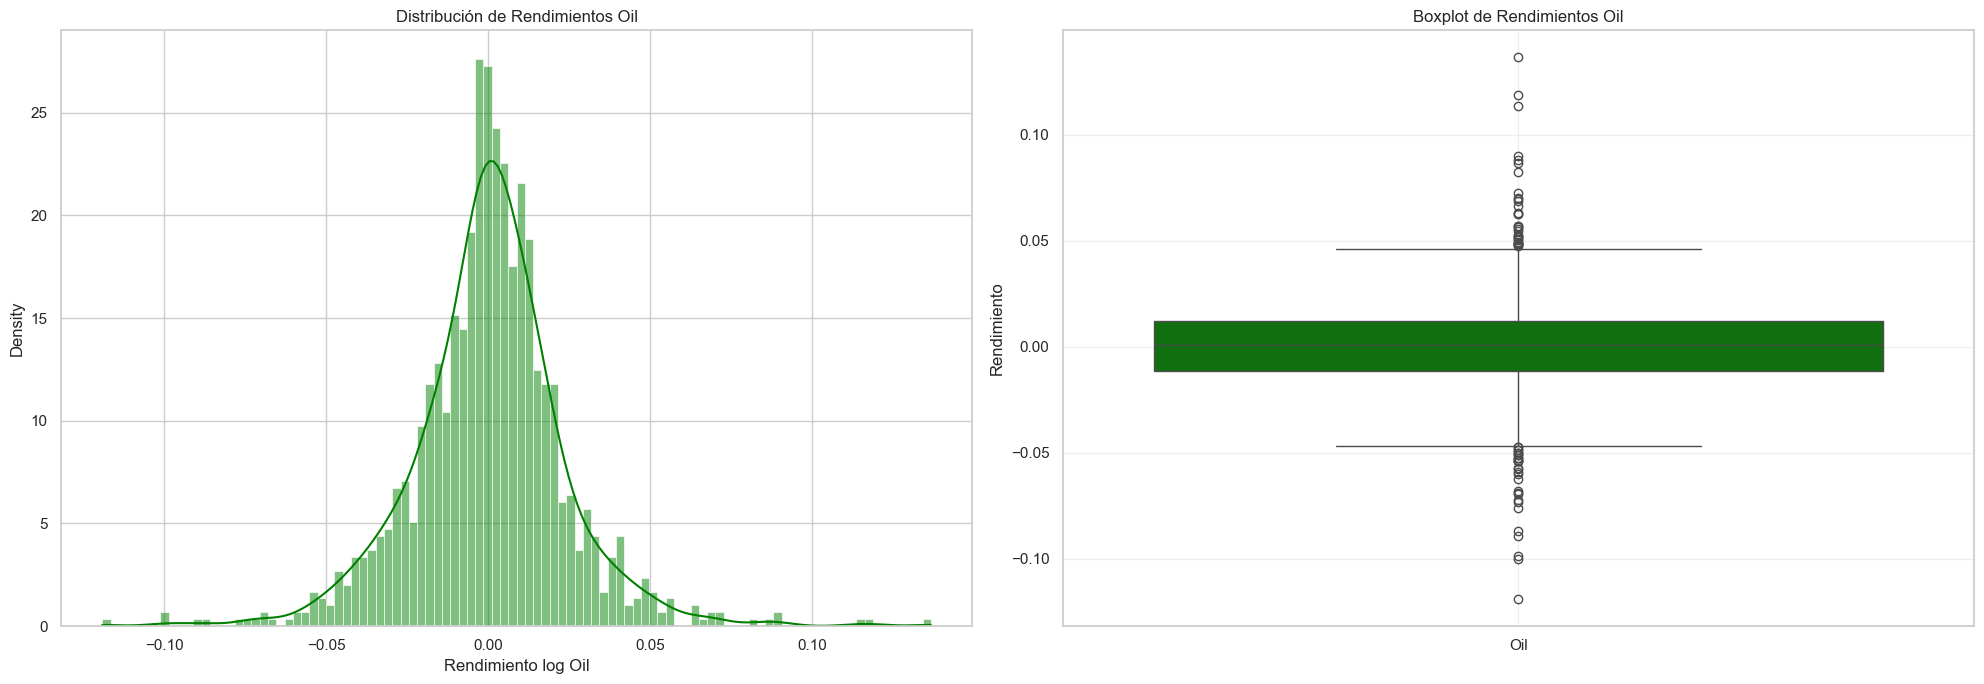

In [102]:
# --- Histograma ---
plt.figure(figsize=(20, 7))

plt.subplot(1,2,1)
sns.histplot(bd["Oil"], bins=100, kde=True, stat="density", color="green")
plt.title("Distribución de Rendimientos Oil")
plt.xlabel("Rendimiento log Oil")
plt.tight_layout()

# --- Boxplot ---
plt.subplot(1,2,2)
sns.boxplot(bd, vert=True, patch_artist=True, color='green')
plt.title("Boxplot de Rendimientos Oil")
plt.ylabel("Rendimiento")
plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()


In [103]:
# Curtosis
kurtosis = bd.kurtosis()
print("Curtosis Empírica:", kurtosis.iloc[0])

# Curtosis teórica de una normal ajustada
kurt_fisher = scipy.stats.norm.stats(loc=0, scale=1, moments='k')  # 'k' = kurtosis de Fisher (exceso)
print("Curtosis Teórica:", float(kurt_fisher) + 3)

Curtosis Empírica: 3.674023794486269
Curtosis Teórica: 3.0


In [104]:
# --- Ajuste por MLE ---
datos = bd.values.flatten()  # convertir a array
mu_mle = np.mean(datos)               # media MLE
sigma_mle = np.std(datos, ddof=0)     # desviación estándar MLE (ddof=0)

print(f"Media MLE: {mu_mle:.6f}")
print(f"Desviación estándar MLE: {sigma_mle:.6f}")

Media MLE: 0.000194
Desviación estándar MLE: 0.023651


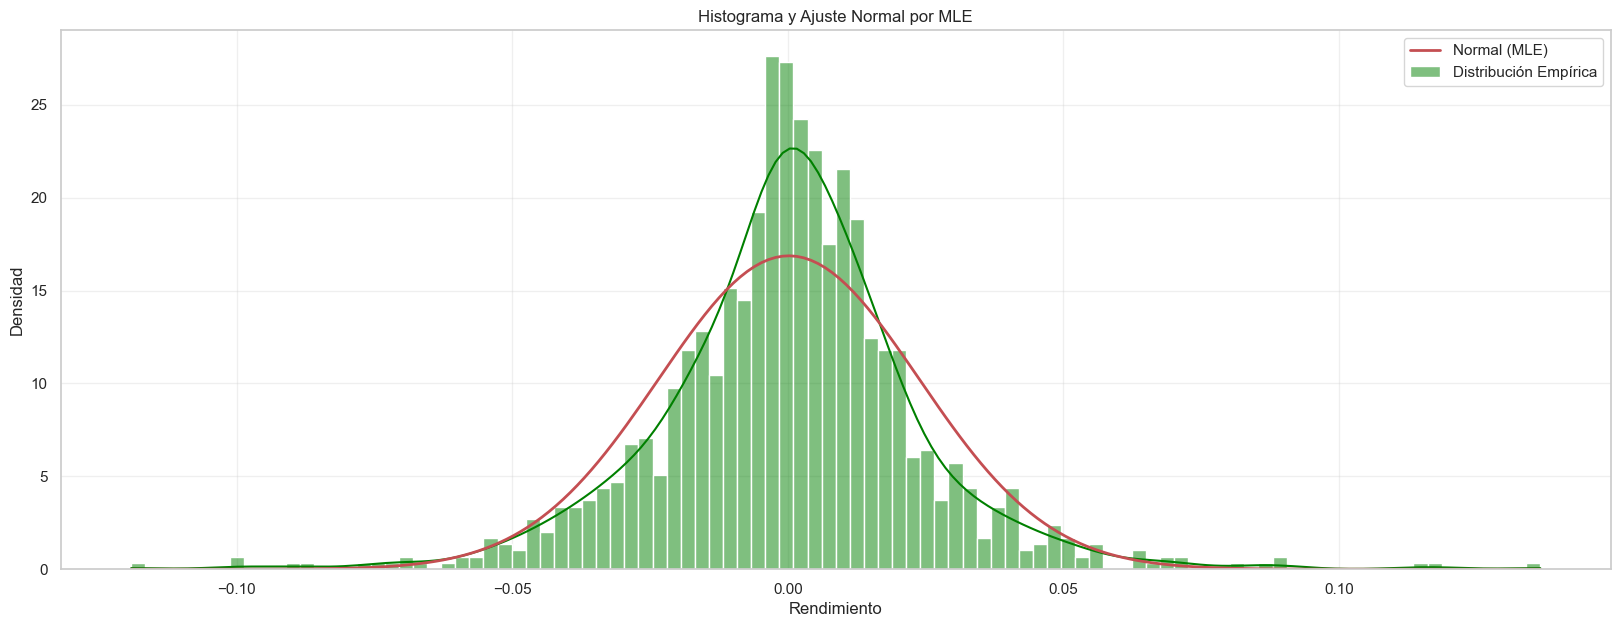

In [106]:
# --- Graficar histograma con densidad normal ---
plt.figure(figsize=(20, 7))
sns.histplot(bd["Oil"], bins=100, kde=True, stat="density", color="green", label='Distribución Empírica')
plt.title("Distribución de Rendimientos Oil")
plt.xlabel("Rendimiento log Oil")

# Curva de la normal ajustada
x = np.linspace(min(datos), max(datos), 200)
pdf = norm.pdf(x, loc=mu_mle, scale=sigma_mle)
plt.plot(x, pdf, 'r-', lw=2, label='Normal (MLE)')

plt.title("Histograma y Ajuste Normal por MLE")
plt.xlabel("Rendimiento")
plt.ylabel("Densidad")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

In [107]:
# KS test para IPC
ks_ipc = kstest(bd["Oil"], "laplace", args=(mu_mle, sigma_mle))
print("KS Test IPC -> estadístico:", ks_ipc.statistic, "  p-value:", ks_ipc.pvalue)

KS Test IPC -> estadístico: 0.08070748225861679   p-value: 5.020160290528356e-07


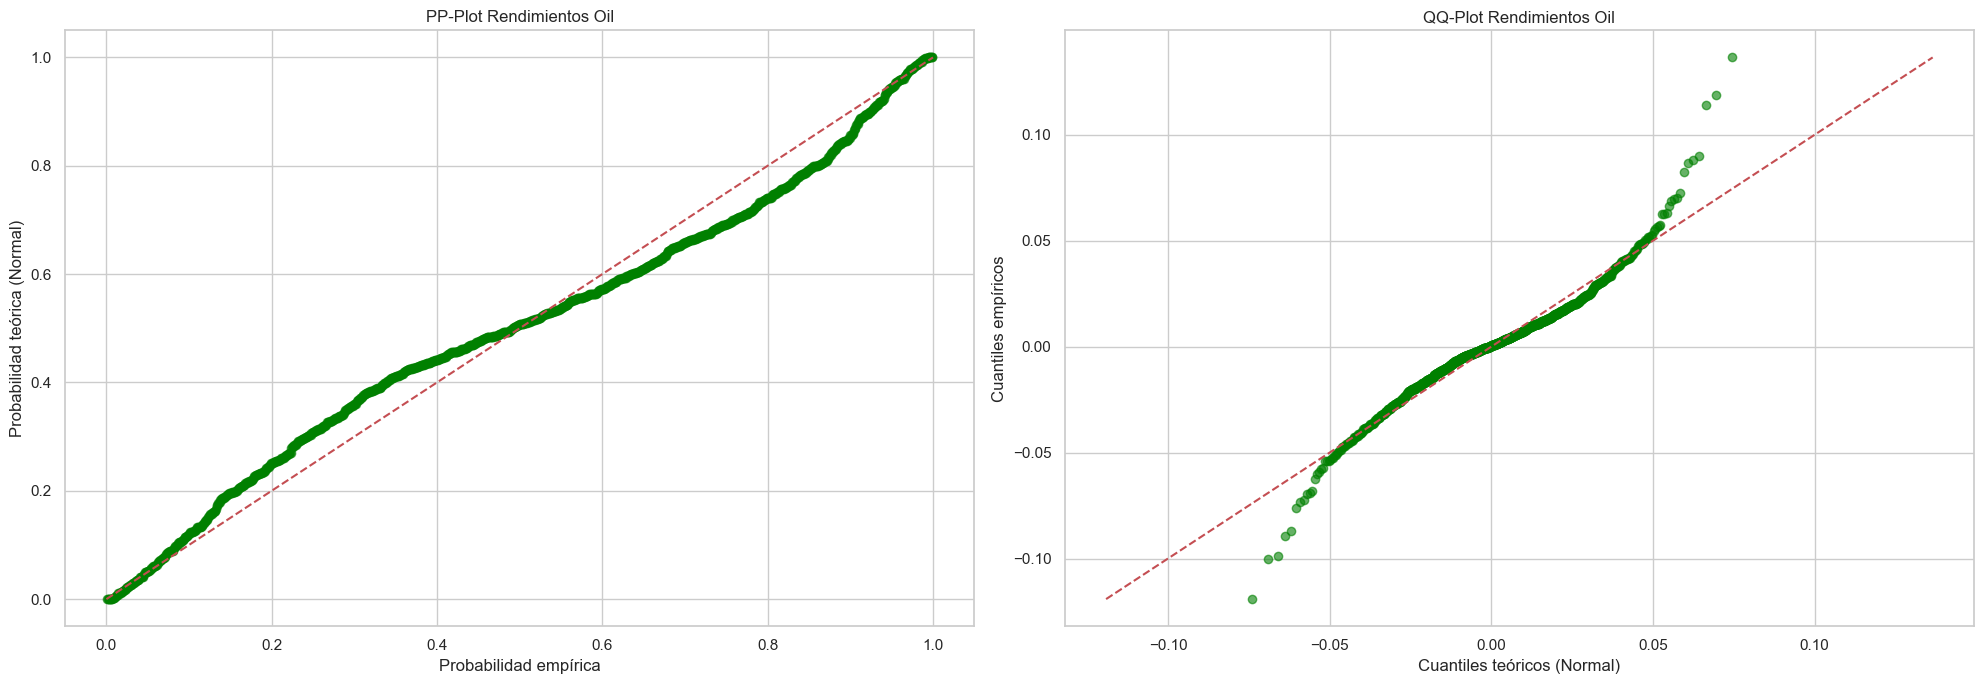

In [108]:
def pp_qq_plots(data, mu, sigma, title_pp="PP-Plot", title_qq="QQ-Plot"):
    data_sorted = np.sort(data)
    n = len(data_sorted)
    probs = np.arange(1, n+1) / (n+1)

    # --- PP Plot ---
    probs_emp = probs
    probs_theo = norm.cdf(data_sorted, loc=mu, scale=sigma)

    # --- QQ Plot ---
    theo_quants = norm.ppf(probs, loc=mu, scale=sigma)

    # --- Crear figura con subplots ---
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # PP-Plot
    axes[0].plot(probs_emp, probs_theo, "o", color='green', alpha=0.6)
    axes[0].plot([0, 1], [0, 1], "r--")
    axes[0].set_xlabel("Probabilidad empírica")
    axes[0].set_ylabel("Probabilidad teórica (Normal)")
    axes[0].set_title(title_pp)
    axes[0].grid(True)

    # QQ-Plot
    axes[1].plot(theo_quants, data_sorted, "o", color='green', alpha=0.6)
    min_val = min(data_sorted.min(), theo_quants.min())
    max_val = max(data_sorted.max(), theo_quants.max())
    axes[1].plot([min_val, max_val], [min_val, max_val], "r--")
    axes[1].set_xlabel("Cuantiles teóricos (Normal)")
    axes[1].set_ylabel("Cuantiles empíricos")
    axes[1].set_title(title_qq)
    axes[1].grid(True)

    plt.tight_layout()
    plt.show()

# Ejemplo con tus datos del IPC
pp_qq_plots(bd["Oil"], mu_mle, sigma_mle,
            title_pp="PP-Plot Rendimientos Oil", title_qq="QQ-Plot Rendimientos Oil")


In [109]:
def gmm_em_1d(x, n_comp=2, max_iter=500, tol=1e-6, seed=42):
    """
    EM para una mezcla de n_comp Normales en 1D.
    Retorna: pis (pesos), mus (medias), sigmas (desvios), loglikes (trayectoria), n_iter (iteraciones usadas).
    """
    rng = np.random.default_rng(seed)
    x = np.asarray(x).ravel()
    n = x.size

    # --- Inicialización sencilla: mu por cuantiles, sigma global, pesos uniformes ---
    qs = np.linspace(0.2, 0.8, n_comp)
    mus = np.quantile(x, qs)
    sigmas = np.full(n_comp, x.std(ddof=0) + 1e-8)
    pis = np.full(n_comp, 1.0 / n_comp)

    def loglike(x, pis, mus, sigmas):
        comp = np.array([pis[k] * scipy.stats.norm.pdf(x, mus[k], sigmas[k]) for k in range(n_comp)])  # k x n
        return np.sum(np.log(np.maximum(comp.sum(axis=0), 1e-300)))

    prev_ll = -np.inf
    loglikes = []

    for it in range(1, max_iter + 1):  # iteraciones contadas desde 1
        # --- E-step: responsabilidades r_{ik} ---
        numer = np.array([pis[k] * scipy.stats.norm.pdf(x, mus[k], sigmas[k]) for k in range(n_comp)])  # k x n
        denom = np.maximum(numer.sum(axis=0), 1e-300)                                       # n
        r = (numer / denom).T                                                               # n x k

        # --- M-step: actualizar parámetros ---
        Nk = r.sum(axis=0)                          # tamaño efectivo de cada componente
        pis = Nk / n
        mus = (r * x[:, None]).sum(axis=0) / Nk
        var = (r * (x[:, None] - mus)**2).sum(axis=0) / Nk
        var = np.maximum(var, 1e-12)                # piso numérico para estabilidad
        sigmas = np.sqrt(var)

        # --- Criterio de convergencia ---
        ll = loglike(x, pis, mus, sigmas)
        loglikes.append(ll)
        if abs(ll - prev_ll) < tol:
            break
        prev_ll = ll

    return pis, mus, sigmas, loglikes, it  # <-- agregamos el número de iteraciones

K óptimo por AIC: 3
K óptimo por BIC: 3


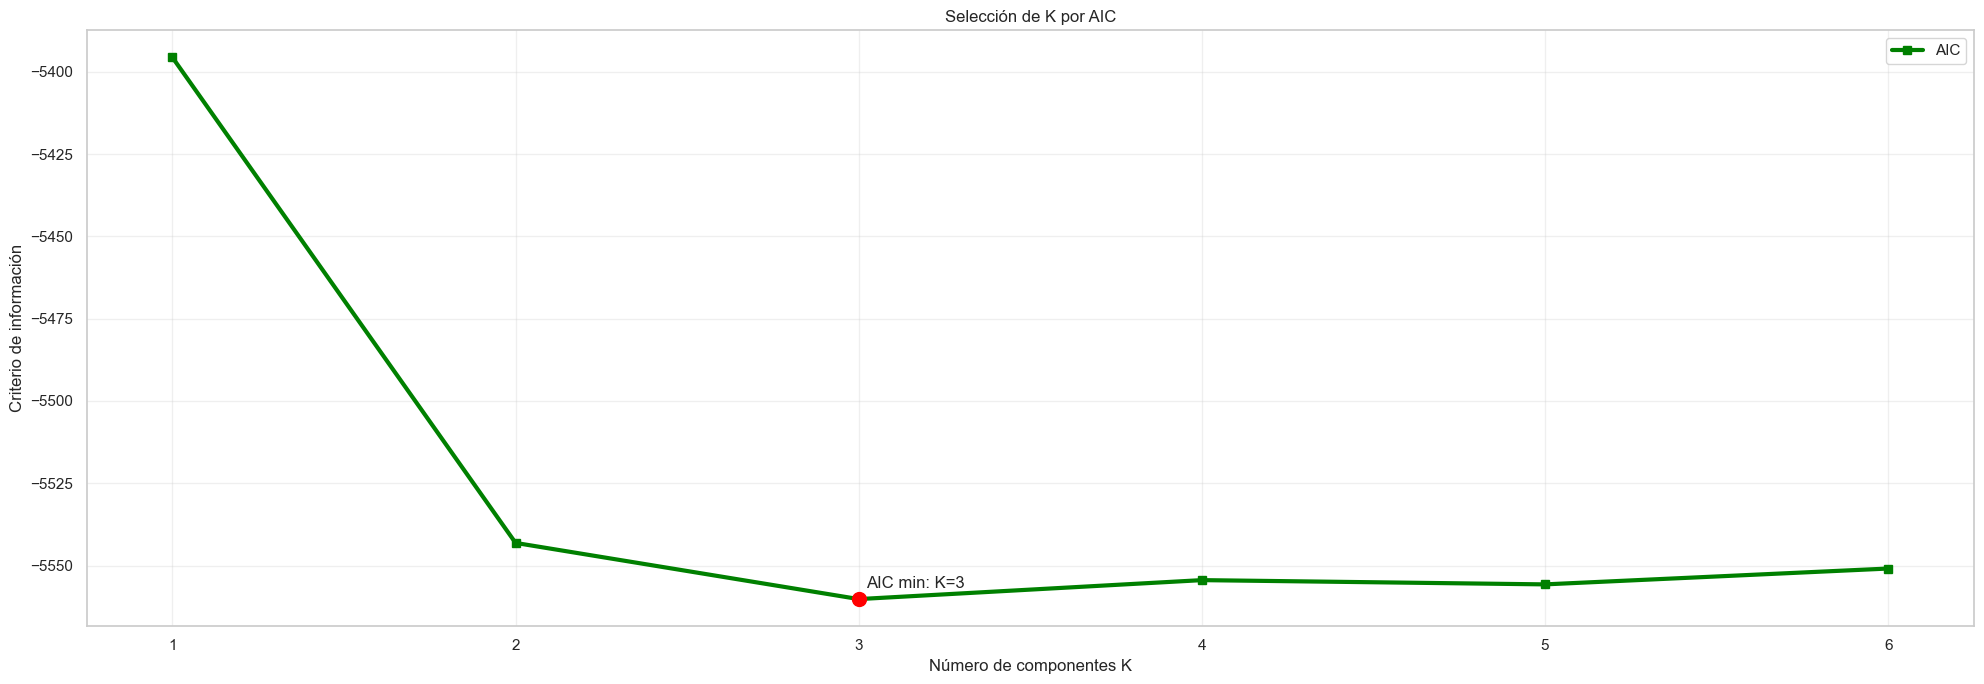


Modelo elegido (BIC): K=3
Pesos: [0.60532983 0.31771389 0.07695628]
Medias: [-0.0014455   0.00235516  0.00416988]
Sigmas: [0.02322183 0.00899228 0.05135093]
Iteraciones: 302


In [111]:
def select_k_by_ic(x, k_max=6, restarts=10, tol=1e-6, max_iter=1000, seeds=None):
    x = np.asarray(x).ravel()
    x = x[np.isfinite(x)]
    n = x.size
    if seeds is None:
        seeds = np.arange(restarts)

    Ks, best_ll, best_params = [], [], []
    AIC, BIC = [], []

    for K in range(1, k_max+1):
        ll_star = -np.inf
        params_star = None

        for s in seeds:
            pis, mus, sigmas, lls, n_iter = gmm_em_1d(
                x, n_comp=K, max_iter=max_iter, tol=tol, seed=int(s)
            )
            ll = lls[-1]
            if ll > ll_star:
                ll_star = ll
                params_star = (pis, mus, sigmas, n_iter)

        p = 3*K - 1  # nº de parámetros en 1D
        aic = 2*p - 2*ll_star
        bic = p*np.log(n) - 2*ll_star

        Ks.append(K)
        best_ll.append(ll_star)
        best_params.append(params_star)
        AIC.append(aic)
        BIC.append(bic)

    Ks = np.array(Ks); AIC = np.array(AIC); BIC = np.array(BIC); best_ll = np.array(best_ll)
    k_aic = Ks[np.argmin(AIC)]
    k_bic = Ks[np.argmin(BIC)]
    return {
        "Ks": Ks, "AIC": AIC, "BIC": BIC, "best_ll": best_ll,
        "k_aic": k_aic, "k_bic": k_bic, "best_params": best_params
    }

# ==== correr selección (ajusta k_max y restarts a tu gusto) ====
x = bd.values.ravel()
res = select_k_by_ic(x, k_max=6, restarts=15, tol=1e-7, max_iter=1000)

print("K óptimo por AIC:", res["k_aic"])
print("K óptimo por BIC:", res["k_bic"])

# ==== gráfico AIC y BIC vs K ====
fig, ax = plt.subplots(figsize=(20,7))
ax.plot(res["Ks"], res["AIC"], marker="s", color='green', label="AIC", lw=3.0)
ax.set_xlabel("Número de componentes K")
ax.set_ylabel("Criterio de información")
ax.set_title("Selección de K por AIC")
ax.grid(alpha=0.3)

# marcar mínimos
ka, kb = res["k_aic"], res["k_bic"]
ya = res["AIC"][res["Ks"]==ka][0]
ax.scatter([ka],[ya], s=100, color='red', zorder=5)
ax.annotate(f"AIC min: K={ka}", (ka, ya), xytext=(5,8), textcoords="offset points")
ax.legend()
plt.tight_layout()
plt.show()



# ==== si quieres quedarte con el modelo óptimo por AIC (menos parsimonioso) ====
K_best = res["k_aic"]
pis_best, mus_best, sigmas_best, n_iter_best = res["best_params"][K_best-1]
print(f"\nModelo elegido (BIC): K={K_best}")
print("Pesos:", pis_best)
print("Medias:", mus_best)
print("Sigmas:", sigmas_best)
print("Iteraciones:", n_iter_best)


In [112]:
# Uso:
x = bd.values  # 1D
pis, mus, sigmas, lls, n_iter = gmm_em_1d(x, n_comp=3, max_iter=1000, tol=1e-6, seed=42)
print(f"Pesos: {pis}")
print(f"Medias: {mus}")
print(f"Sigmas: {sigmas}")
print(f"Iteraciones usadas: {n_iter}")
print(f"Log-like final: {lls[-1]:.4f}")

Pesos: [0.60508225 0.31789709 0.07702066]
Medias: [-0.00144709  0.00235502  0.00416917]
Sigmas: [0.02322298 0.00899553 0.05133757]
Iteraciones usadas: 266
Log-like final: 2788.0962


Pesos: [0.60508225 0.31789709 0.07702066]
Medias: [-0.00144709  0.00235502  0.00416917]
Sigmas: [0.02322298 0.00899553 0.05133757]
Iteraciones usadas: 266
Log-like final: 2788.0962


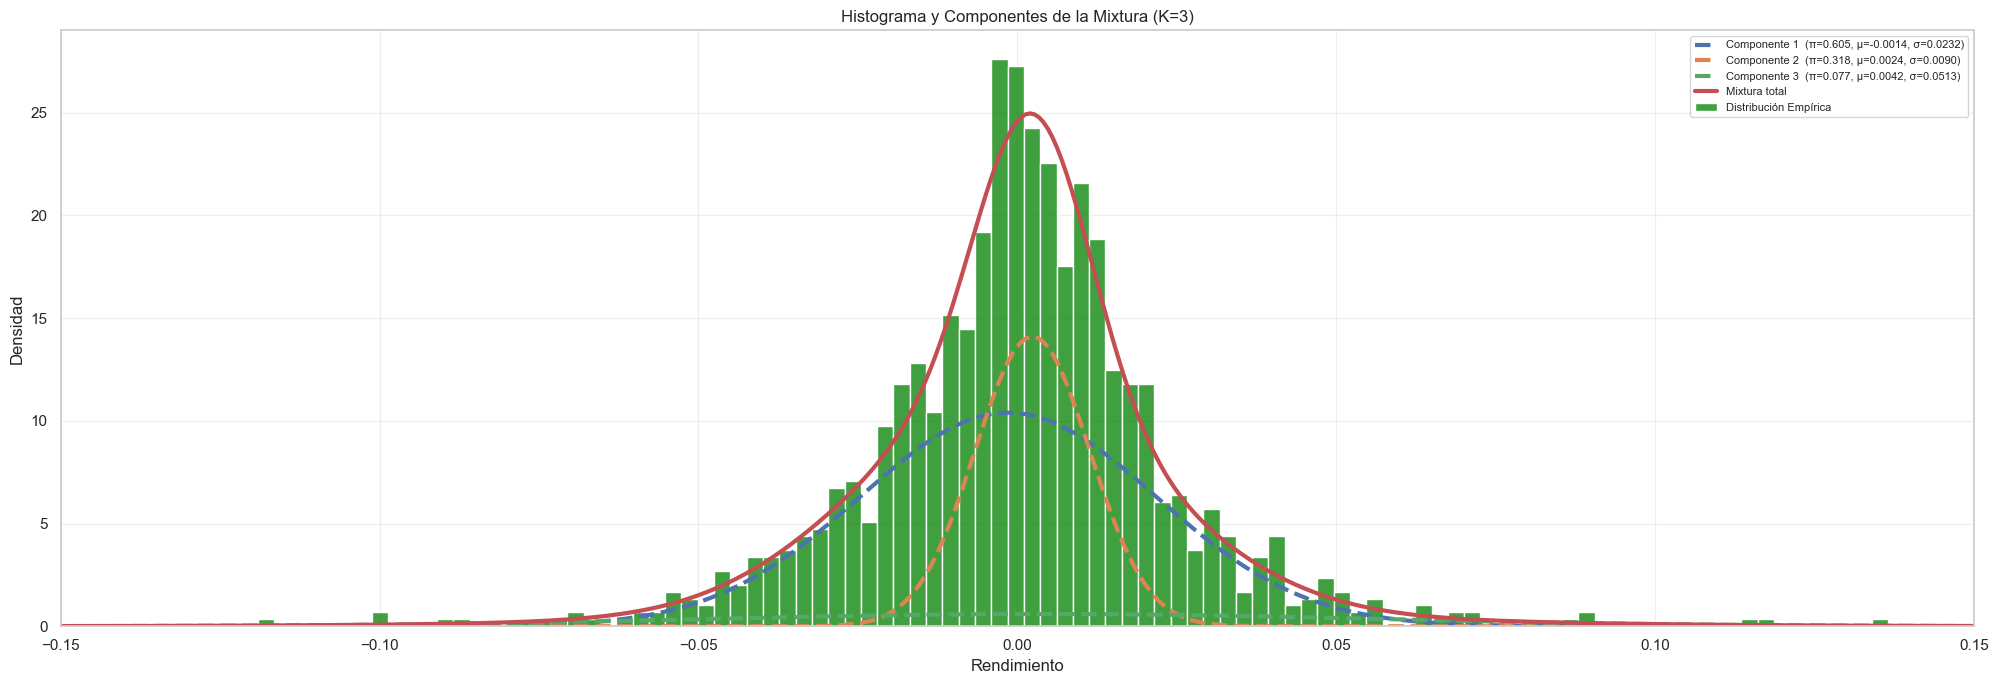

In [116]:
def plot_gmm_1d(x, pis, mus, sigmas, bins=80, title="Mixtura Gaussiana (componentes + total)"):
    """
    x: datos 1D
    pis, mus, sigmas: parámetros de la mezcla (longitud K)
    """
    # asegurar 1D y finitos
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]
    pis   = np.asarray(pis, dtype=float).ravel()
    mus   = np.asarray(mus, dtype=float).ravel()
    sigmas= np.asarray(sigmas, dtype=float).ravel()
    K = len(pis)

    # rango para graficar
    lo = (x.min() if x.size else -1) - 3*np.max(sigmas)
    hi = (x.max() if x.size else  1) + 3*np.max(sigmas)
    xg = np.linspace(lo, hi, 800)

    # figura
    plt.figure(figsize=(20,7))
    # histograma (densidad)
    sns.histplot(bd["Oil"], bins=100, stat="density", color="green", label='Distribución Empírica')

    # componentes y mezcla
    mix_pdf = np.zeros_like(xg)
    for k in range(K):
        comp_pdf = pis[k] * norm.pdf(xg, loc=float(mus[k]), scale=float(sigmas[k]))
        mix_pdf += comp_pdf
        plt.plot(xg, comp_pdf, "--", lw=3,
                 label=f"Componente {k+1}  (π={pis[k]:.3f}, μ={mus[k]:.4f}, σ={sigmas[k]:.4f})")

    # mezcla total
    plt.plot(xg, mix_pdf, "r", lw=3, label="Mixtura total")

    plt.title(title)
    plt.xlabel("Rendimiento")
    plt.ylabel("Densidad")
    plt.grid(alpha=0.3)
    plt.legend(loc="upper right", fontsize=8)
    plt.tight_layout()
    plt.xlim(-0.15, 0.15)
    plt.show()

# Ajuste (ya lo tienes)
x = bd.values.ravel()   # 1D
pis, mus, sigmas, lls, n_iter = gmm_em_1d(x, n_comp=3, max_iter=1000, tol=1e-6, seed=42)
print(f"Pesos: {pis}")
print(f"Medias: {mus}")
print(f"Sigmas: {sigmas}")
print(f"Iteraciones usadas: {n_iter}")
print(f"Log-like final: {lls[-1]:.4f}")

# Gráfico
plot_gmm_1d(x, pis, mus, sigmas, bins=100,
            title="Histograma y Componentes de la Mixtura (K=3)")

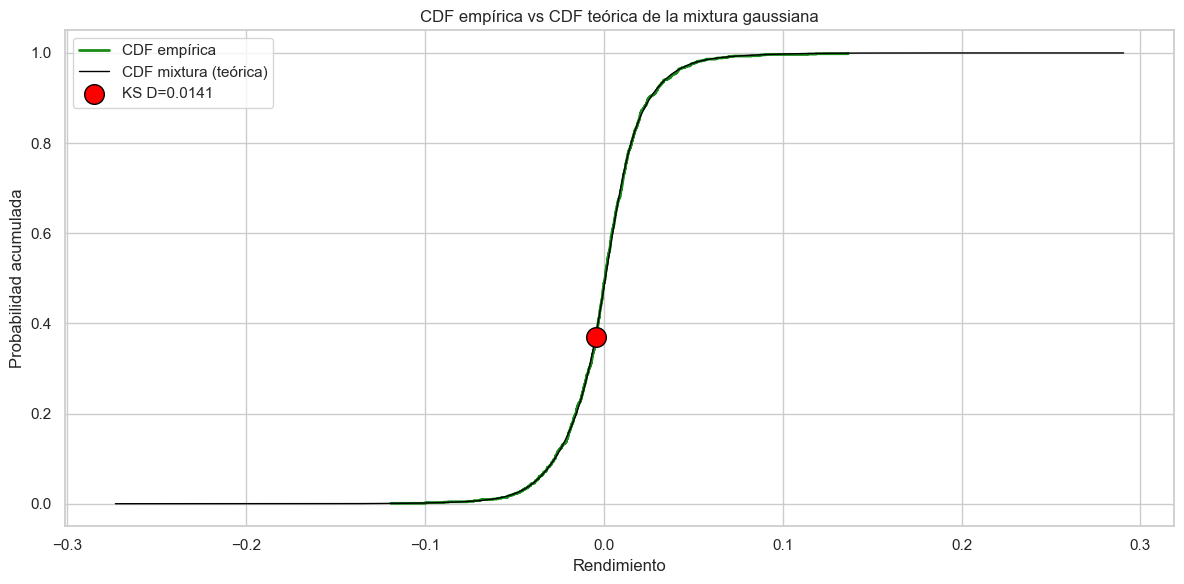

In [118]:
# --- CDF de la mezcla ---
def mix_cdf(x, pis, mus, sigmas):
    x = np.asarray(x)
    pis, mus, sigmas = map(np.asarray, (pis, mus, sigmas))
    z = (x[..., None] - mus) / sigmas
    return np.sum(pis * norm.cdf(z), axis=-1)

# --- ECDF (CDF empírica) ---
def ecdf(x):
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]
    x_sorted = np.sort(x)
    n = x_sorted.size
    y = np.arange(1, n+1) / (n+1)
    return x_sorted, y

def plot_cdfs_vs_mixture(x, pis, mus, sigmas, show_ks=True,
                         title="CDF empírica vs CDF de la Mixtura"):
    x = np.asarray(x, dtype=float).ravel()
    x = x[np.isfinite(x)]

    # ECDF
    xs_emp, F_emp = ecdf(x)

    # Grid para la mezcla
    lo = xs_emp.min() - 3*np.max(sigmas)
    hi = xs_emp.max() + 3*np.max(sigmas)
    xg = np.linspace(lo, hi, 1000)
    F_mix = mix_cdf(xg, pis, mus, sigmas)

    sns.set_theme(style="whitegrid")
    plt.figure(figsize=(12,6))

    # CDF empírica (escalones)
    plt.step(xs_emp, F_emp, where="post", label="CDF empírica",
             linewidth=2, alpha=0.9, color='green')

    # CDF teórica (mezcla)
    plt.plot(xg, F_mix, label="CDF mixtura (teórica)",
             linewidth=1, color='black')

    if show_ks:
        F_mix_emp_pts = mix_cdf(xs_emp, pis, mus, sigmas)
        diffs = np.abs(F_emp - F_mix_emp_pts)
        i_star = np.argmax(diffs)
        D = diffs[i_star]
        x_star = xs_emp[i_star]
        y_star = (F_emp[i_star] + F_mix_emp_pts[i_star]) / 2  # punto medio entre ambas CDF

        # Dibujar un marcador circular grande en el punto KS
        plt.scatter(x_star, y_star, s=200, color='red', marker='o',
                    edgecolor='black', zorder=5,
                    label=f"KS D={D:.4f}")

    plt.title(title)
    plt.xlabel("Rendimiento")
    plt.ylabel("Probabilidad acumulada")
    plt.legend()
    plt.tight_layout()
    plt.show()

# Uso
x = bd.values.ravel()
pis, mus, sigmas, lls, n_iter = gmm_em_1d(x, n_comp=3, max_iter=1000, tol=1e-7, seed=42)
plot_cdfs_vs_mixture(x, pis, mus, sigmas,
                     title="CDF empírica vs CDF teórica de la mixtura gaussiana")

In [119]:
def sample_gmm_1d(n, pis, mus, sigmas, seed=42):
    rng = np.random.default_rng(seed)
    ks = rng.choice(len(pis), size=n, p=pis)
    return rng.normal(mus[ks], sigmas[ks])

# Curtosis
kurtosis = bd.kurtosis()
print("Curtosis Empírica:", kurtosis.iloc[0])

x_sim = sample_gmm_1d(1000000, pis, mus, sigmas, seed=42)
print("Curtosis Teórica (Mixtura):", scipy.stats.kurtosis(x_sim, fisher=False))

Curtosis Empírica: 3.674023794486269
Curtosis Teórica (Mixtura): 6.975484536468108


In [120]:
# KS contra la mezcla
def mix_cdf(x, pis, mus, sigmas):
    """
    CDF de la mezcla: F(x) = sum_k π_k * Φ((x-μ_k)/σ_k)
    """
    x = np.asarray(x)
    pis, mus, sigmas = map(np.asarray, (pis, mus, sigmas))
    z = (x[..., None] - mus) / sigmas
    return np.sum(pis * norm.cdf(z), axis=-1)
ks_mixture = kstest(x, lambda val: mix_cdf(val, pis, mus, sigmas))
print("\nKS test contra Mixtura Gaussiana")
print("Estadístico D:", ks_mixture.statistic)
print("p-valor:", ks_mixture.pvalue)


KS test contra Mixtura Gaussiana
Estadístico D: 0.01467997915311986
p-valor: 0.9606722826951702


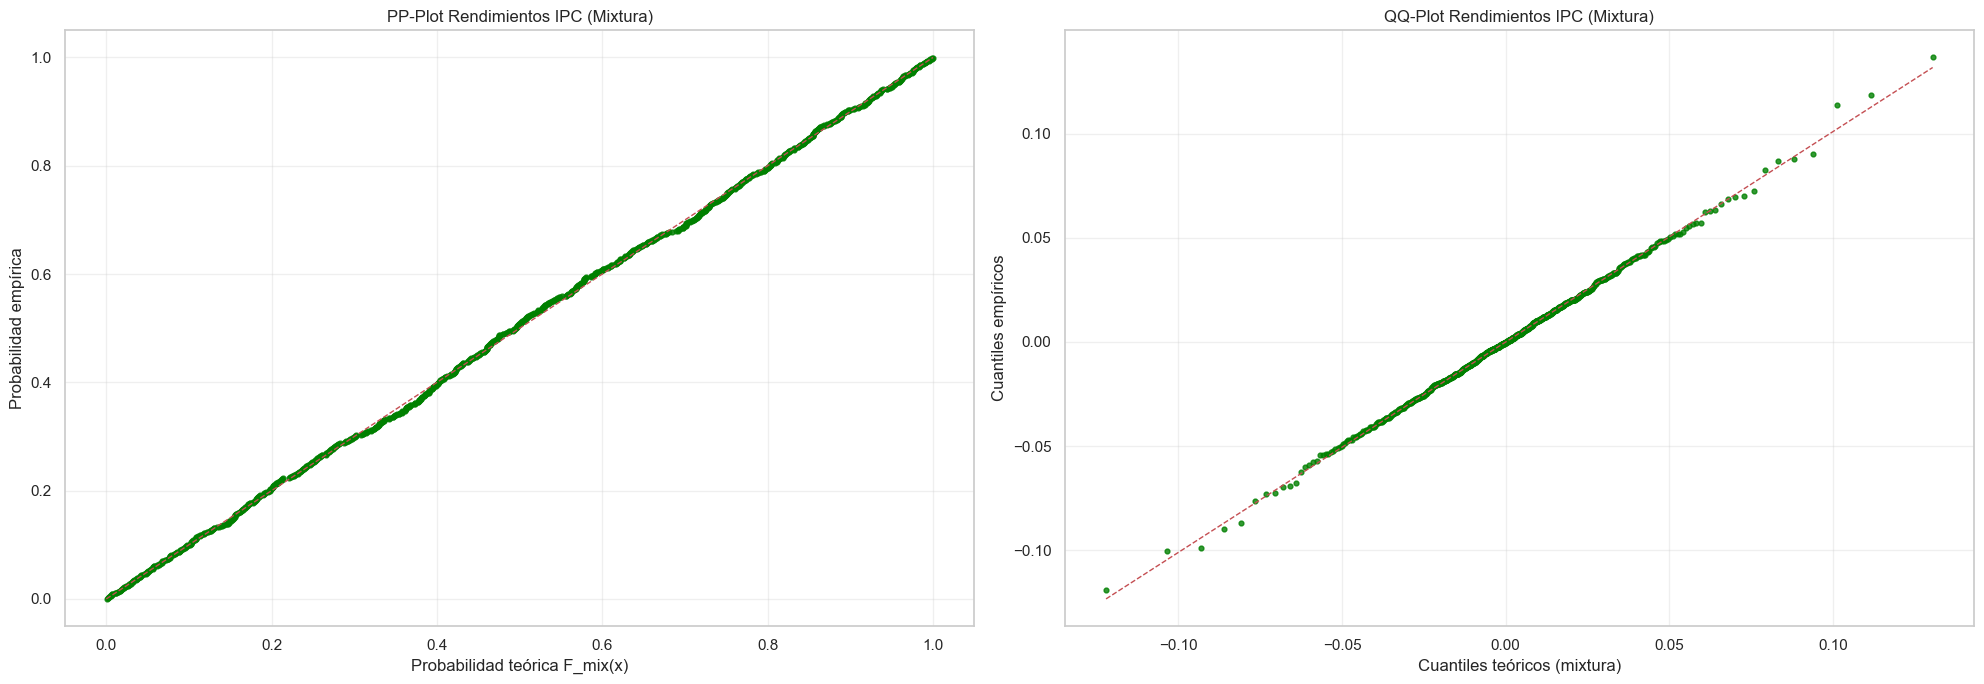

In [121]:
def pp_qq_plots_mixture(x, pis, mus, sigmas, title_pp="PP-Plot vs Mixtura", title_qq="QQ-Plot vs Mixtura"):
    x = np.asarray(x).ravel()
    x = x[~np.isnan(x)]
    n = x.size
    xs = np.sort(x)

    # Probabilidades "Blom"
    p_emp = (np.arange(1, n + 1) - 0.375) / (n + 0.25)

    # ---- PP-Plot ----
    p_th = np.sum(pis * norm.cdf((xs[:, None] - mus) / sigmas), axis=1)

    # ---- QQ-Plot ----
    def mix_cdf(x):
        z = (x[..., None] - mus) / sigmas
        return np.sum(pis * norm.cdf(z), axis=-1)

    def mix_ppf(p, tol=1e-10, max_iter=200):
        lo = np.min(mus - 10 * sigmas.max())
        hi = np.max(mus + 10 * sigmas.max())
        lo = np.full_like(p, lo, dtype=float)
        hi = np.full_like(p, hi, dtype=float)
        for _ in range(max_iter):
            mid = (lo + hi) / 2.0
            Fmid = mix_cdf(mid)
            lo = np.where(Fmid < p, mid, lo)
            hi = np.where(Fmid >= p, mid, hi)
            if np.max(hi - lo) < tol:
                break
        return (lo + hi) / 2.0

    q_th = mix_ppf(p_emp)

    # ---- Subplots ----
    fig, axes = plt.subplots(1, 2, figsize=(20, 7))

    # PP-Plot
    axes[0].scatter(p_th, p_emp, s=12, color='green', alpha=0.8)
    axes[0].plot([0, 1], [0, 1], 'r--', lw=1)
    axes[0].set_xlabel("Probabilidad teórica F_mix(x)")
    axes[0].set_ylabel("Probabilidad empírica")
    axes[0].set_title(title_pp)
    axes[0].grid(alpha=0.3)

    # QQ-Plot
    axes[1].scatter(q_th, xs, s=12, color='green', alpha=0.8)
    q25_th, q75_th = np.quantile(q_th, [0.25, 0.75])
    q25_xs, q75_xs = np.quantile(xs, [0.25, 0.75])
    slope = (q75_xs - q25_xs) / (q75_th - q25_th + 1e-18)
    intercept = q25_xs - slope * q25_th
    xr = np.array([q_th.min(), q_th.max()])
    axes[1].plot(xr, slope * xr + intercept, 'r--', lw=1)
    axes[1].set_xlabel("Cuantiles teóricos (mixtura)")
    axes[1].set_ylabel("Cuantiles empíricos")
    axes[1].set_title(title_qq)
    axes[1].grid(alpha=0.3)

    plt.tight_layout()
    plt.show()

# ==========
# Uso con tus datos
# ==========
x = bd.dropna().values
pp_qq_plots_mixture(x, pis, mus, sigmas,
                    title_pp="PP-Plot Rendimientos IPC (Mixtura)",
                    title_qq="QQ-Plot Rendimientos IPC (Mixtura)")


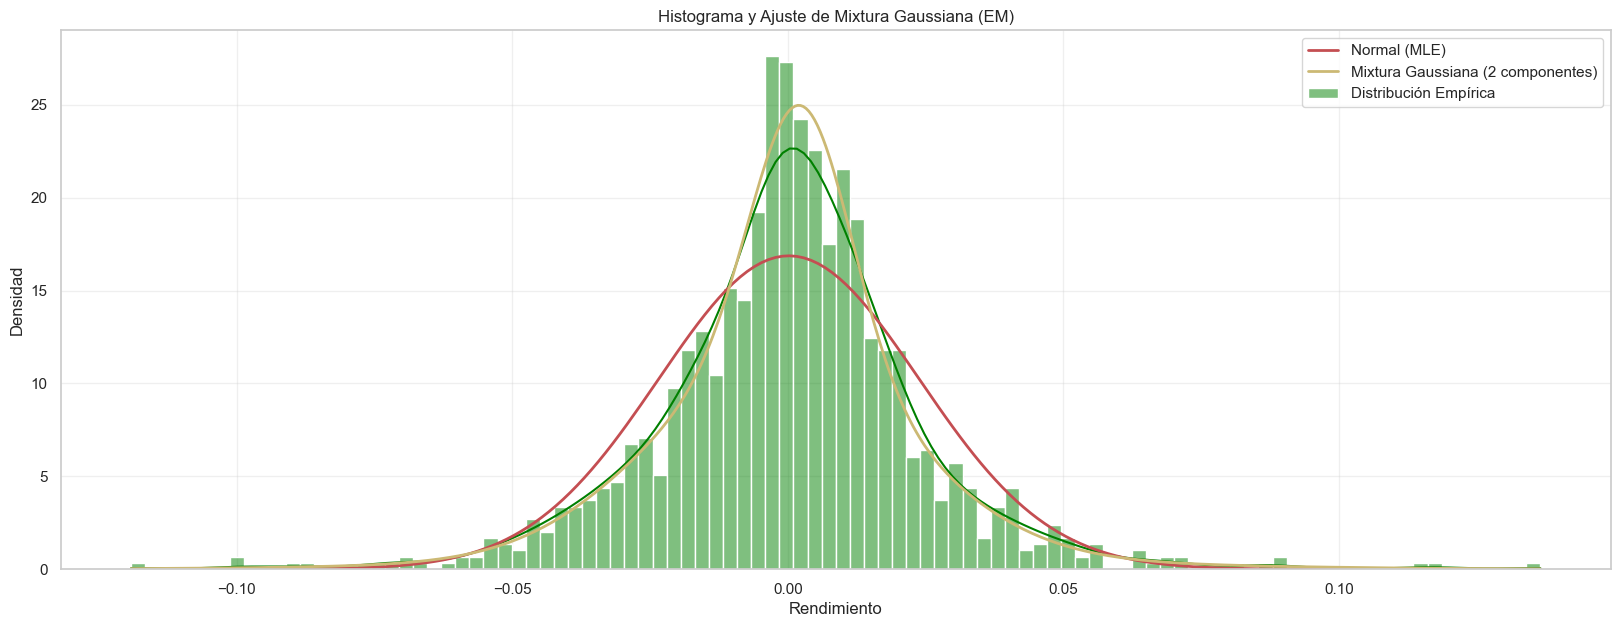

In [122]:
# --- Histograma con KDE de los datos ---
plt.figure(figsize=(20, 7))
sns.histplot(bd["Oil"], bins=100, kde=True, stat="density",
             color="green", label='Distribución Empírica')

plt.title("Histograma y Ajuste de Mixtura Gaussiana (EM)")
plt.xlabel("Rendimiento")
plt.ylabel("Densidad")

# Curva de la normal ajustada
x = np.linspace(min(datos), max(datos), 200)
pdf = scipy.stats.norm.pdf(x, loc=mu_mle, scale=sigma_mle)
plt.plot(x, pdf, 'r-', lw=2, label='Normal (MLE)')

# --- Densidad de la mezcla ---
x_grid = np.linspace(bd["Oil"].min(), bd["Oil"].max(), 500)
pdf_mix = np.zeros_like(x_grid)

for pi, mu, sigma in zip(pis, mus, sigmas):
    pdf_mix += pi * norm.pdf(x_grid, loc=mu, scale=sigma)

plt.plot(x_grid, pdf_mix, 'y-', lw=2, label='Mixtura Gaussiana (2 componentes)')

plt.legend()
plt.grid(alpha=0.3)
plt.show()

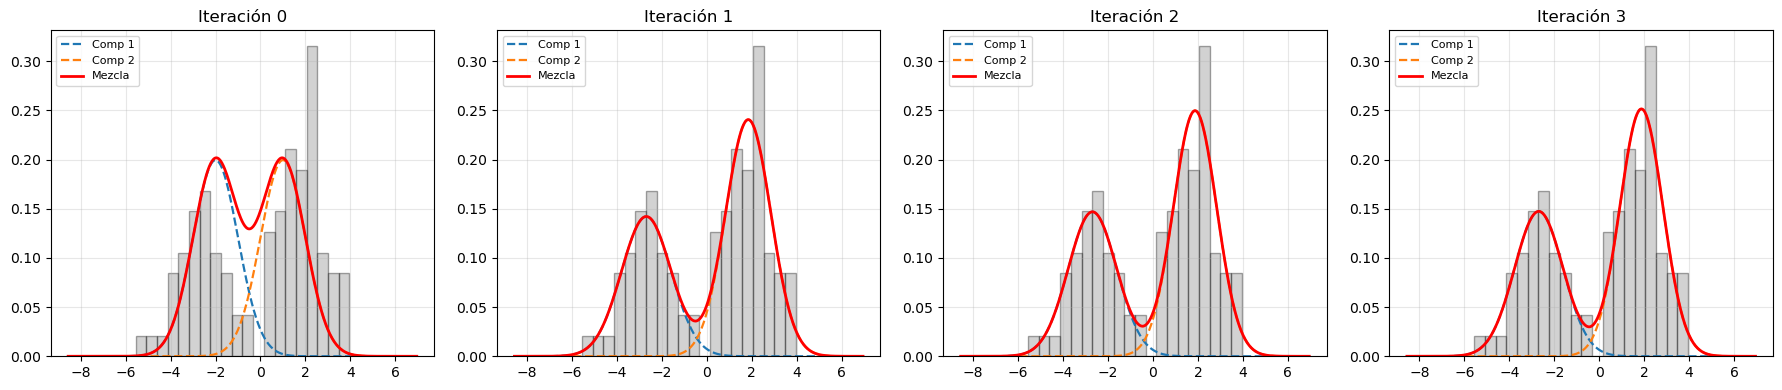

In [3]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- Datos sintéticos (puedes usar los tuyos) ---
np.random.seed(0)
x = np.concatenate([np.random.normal(-3, 1, 40),
                    np.random.normal(+2, 1, 60)])
x = np.asarray(x, dtype=float).ravel()   # <-- 1D

# --- Inicialización (asegurar 1D) ---
pis   = np.array([0.5, 0.5], dtype=float).ravel()
mus   = np.array([-2.0, 1.0], dtype=float).ravel()
sigmas= np.array([1.0, 1.0], dtype=float).ravel()

def e_step(x, pis, mus, sigmas):
    # asegurar 1D
    pis   = np.asarray(pis, dtype=float).ravel()
    mus   = np.asarray(mus, dtype=float).ravel()
    sigmas= np.asarray(sigmas, dtype=float).ravel()
    # responsabilidades (n x K)
    comps = np.array([pis[k] * norm.pdf(x, loc=mus[k], scale=sigmas[k]) for k in range(len(pis))])  # K x n
    denom = np.maximum(comps.sum(axis=0), 1e-300)  # n
    r = (comps / denom).T                          # n x K
    return r

def m_step(x, r):
    # tamaños efectivos
    Nk = r.sum(axis=0)                              # (K,)
    # pesos
    pis = Nk / len(x)                               # (K,)
    # medias ponderadas
    mus = (r * x[:, None]).sum(axis=0) / Nk         # (K,)
    # varianzas ponderadas
    var = (r * (x[:, None] - mus)**2).sum(axis=0) / Nk
    var = np.maximum(var, 1e-12)                    # piso numérico
    sigmas = np.sqrt(var)                           # (K,)
    # asegurar 1D
    return pis.ravel(), mus.ravel(), sigmas.ravel()

# --- Visualización de 4 iteraciones ---
fig, axes = plt.subplots(1, 4, figsize=(18, 4))
xg = np.linspace(x.min()-3, x.max()+3, 500)

for i, ax in enumerate(axes):
    # Histograma
    ax.hist(x, bins=20, density=True, alpha=0.35, color='gray', edgecolor='k')

    # Mezcla y componentes (¡aquí estaba el error!)
    # Aseguramos que mus[k] y sigmas[k] son escalares
    mix_pdf = np.zeros_like(xg)
    for k in range(len(pis)):
        comp_pdf = pis[k] * norm.pdf(xg, loc=float(mus[k]), scale=float(sigmas[k]))
        ax.plot(xg, comp_pdf, '--', lw=1.6, label=f'Comp {k+1}')
        mix_pdf += comp_pdf
    ax.plot(xg, mix_pdf, 'r', lw=2, label='Mezcla')

    ax.set_title(f"Iteración {i}")
    ax.grid(alpha=0.3)
    ax.legend(loc='upper left', fontsize=8)

    # EM step
    r = e_step(x, pis, mus, sigmas)
    pis, mus, sigmas = m_step(x, r)

plt.tight_layout()
plt.show()

